In [2]:
import argparse
import time
import math
import os
import torch
import torch.nn as nn
import torch.onnx
import torch.optim as optim

import data
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
# Defining FNNModel
class FNNModelDropout(nn.Module):
    """
    Container module with an encoder, a feedforward module, and a decoder.
    Uses Dropout.
    """

    def __init__(self, vocab_size, input_dim, hidden_dim, ngram_size, tie_weights, dropout):
        super(FNNModelDropout, self).__init__() # Inherited from the parent class nn.Module
        self.vocab_size = vocab_size # number of tokens in the corpus dictionary
        self.ngram_size = ngram_size
        self.input_dim = input_dim
        
        # vocab_size - vocab, input_dim - dimensionality of the embeddings
        self.encoder = nn.Embedding(vocab_size, input_dim) # used to store word embeddings and retrieve them using indices
        
        # Declaring the layers
        self.input = nn.Linear(ngram_size * input_dim, hidden_dim) # linear layer (input)
        self.hidden = nn.Tanh() # Second layer - tahn activation layer (non-linearity layer)
        self.decoder = nn.Linear(hidden_dim, vocab_size, bias = False ) # decoder - linearity layer
        self.dropout = nn.Dropout(dropout)
        
        if tie_weights:
            if hidden_dim != input_dim:
                raise ValueError('When using the tied flag, nhid must be equal to emsize')
            self.decoder.weight = self.encoder.weight

        self.init_weights()
        self.nhid = hidden_dim
       

    def init_weights(self):
        initrange = 0.1
        nn.init.uniform_(self.encoder.weight, -initrange, initrange)
        nn.init.zeros_(self.decoder.weight)
        nn.init.uniform_(self.decoder.weight, -initrange, initrange)

    def forward(self, input): # Forward pass: stacking each layer together 
        emb = self.encoder(input).view((-1,self.ngram_size*self.input_dim))
        x = self.input(emb) 
        output = self.hidden(x) # applying tanh
        decoded = self.dropout(self.decoder(output))
        decoded = decoded.view(-1, self.vocab_size)
        log_probs = F.log_softmax(decoded, dim=1) # applies log after softmax - output
        return log_probs 

In [14]:
class Args:
  data = './data/wikitext-2'
  model = 'FNNModel'
  emsize = 200
  nhid = 100
  nlayers = 2
  lr = 0.001
  clip = 0.25
  epochs = 20
  batch_size = 35
  bptt = 35
  dropout = 0.3
  tied = True
  seed = 1111
  cuda = True
  log_interval = 200
  save = 'model_dropout.pt'
  onnx_export = ''
  nhead = 2
  dry_run = False
  ngram_size = 7

args=Args()

In [15]:
# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

In [16]:
###############################################################################
# Load data
###############################################################################

corpus = data.Corpus(args.data)

# Starting from sequential data, batchify arranges the dataset into columns.
# For instance, with the alphabet as the sequence and batch size 4, we'd get
# ┌ a g m s ┐
# │ b h n t │
# │ c i o u │
# │ d j p v │
# │ e k q w │
# └ f l r x ┘.
# These columns are treated as independent by the model, which means that the
# dependence of e. g. 'g' on 'f' can not be learned, but allows more efficient
# batch processing.

def split_ngram(data, bsz):
    value=[]
    data = data.numpy()
    for i,word in enumerate(data):
        if i+bsz>= len(data):
            # sentence boundary reached
            # ignoring sentence less than 8 words
            break
        # convert word to id
        value1 = []
        for j in range(bsz+1):
            value1.append(data[i+j])
        value.append(value1)
    value = torch.LongTensor(value)
    return value.to(device)

eval_ngram_size = 7
train_data = split_ngram(corpus.train, args.ngram_size)
val_data = split_ngram(corpus.valid, eval_ngram_size)
test_data = split_ngram(corpus.test, eval_ngram_size)

In [17]:
###############################################################################
# Build the model (ii)
###############################################################################

ntokens = len(corpus.dictionary)
model = FNNModelDropout(ntokens, args.emsize, args.nhid, args.ngram_size, False, args.dropout).to(device)

# using negative log likelihood
criterion = nn.NLLLoss()

In [18]:
###############################################################################
# Training code
###############################################################################

# get_batch subdivides the source data into chunks of length args.batch_size.
# If source is equal to the example output of the batchify function, with
# a batch size-limit of 2, we'd get the following two Variables for i = 0:
# ┌ a g m s ┐ ┌ b h n t ┐
# └ b h n t ┘ └ c i o u ┘
# Note that despite the name of the function, the subdivison of data is not
# done along the batch dimension (i.e. dimension 1), since that was handled
# by the batchify function. 

def get_batch(source, i):
    seq_len = min(args.batch_size, len(source) - 1 - i)
    data = source[i:i+seq_len, 0:args.ngram_size] # first 7
    target = source[i+1:i+1+seq_len, args.ngram_size-1:args.ngram_size] # last 1
    target = target.narrow(1,0,1).contiguous().view(-1)
    return data, target

def evaluate(data_source):
    # Turn on evaluation mode which disables dropout.
    model.eval()
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, data_source.size(0) - 1, args.batch_size):
            data, targets = get_batch(data_source, i)
            data, targets = data.to(device), targets.to(device)
            output = model(data)
            total_loss += len(data) * criterion(output, targets).item()
    return total_loss / (len(data_source) - 1)


def train():
    # Turn on training mode which enables dropout.
    model.train()
    
    # using ADAM optimizer
    optimizer = optim.Adam(model.parameters(), lr = args.lr)
    
    total_loss = 0
    start_time = time.time()
    ntokens = len(corpus.dictionary)
    for batch, i in enumerate(range(0, train_data.size(0) - 1, args.batch_size)):
        data, targets = get_batch(train_data, i)
        data, targets = data.to(device), targets.to(device)
        model.zero_grad() # zero out the gradients from the old instance
        output = model(data)
        loss = criterion(output, targets)
        loss.backward()
        
        optimizer.step()

        total_loss += loss.item()

        if batch % args.log_interval == 0 and batch > 0:
            cur_loss = total_loss / args.log_interval
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches | lr {:02.4f} | ms/batch {:5.2f} | '
                    'loss {:5.2f} | ppl {:8.2f}'.format(
                epoch, batch, len(train_data) // args.batch_size, lr,
                elapsed * 1000 / args.log_interval, cur_loss, math.exp(cur_loss)))
            total_loss = 0
            start_time = time.time()
        if args.dry_run:
            print("BREAK")
            break
            

def export_onnx(path, batch_size, seq_len):
    print('The model is also exported in ONNX format at {}'.
          format(os.path.realpath(args.onnx_export)))
    model.eval()
    dummy_input = torch.LongTensor(seq_len * batch_size).zero_().view(-1, batch_size).to(device)
    torch.onnx.export(model, dummy_input, path)

In [19]:
###############################################################################
# Main code --> (iii) - (v)
###############################################################################

print('-' * 89)
print('--- Part iii ---')
print('-'*89)

# Loop over epochs.
lr = args.lr
best_val_loss = None
best_perplexity = 999999999999999

#Empty arrray to store perplexity & epoch
perplexity_plot_iii = []
epoch_plot_iii = []

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        
        # Save the model if the perplexity is the best seen
        perplexity = math.exp(val_loss)
        perplexity_plot_iii.append(perplexity)
        epoch_plot_iii.append(epoch)
        if perplexity < best_perplexity:
            print(perplexity)
            with open(args.save, 'wb') as f:
                torch.save(model, f)
                
            best_perplexity = perplexity
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
print('=' * 89)

# saving to onnx format
if len(args.onnx_export) > 0:
    # Export the model in ONNX format.
    export_onnx(args.onnx_export, batch_size=1, seq_len=args.batch_size)

-----------------------------------------------------------------------------------------
--- Part iii ---
-----------------------------------------------------------------------------------------
| epoch   1 |   200/59674 batches | lr 0.0010 | ms/batch  4.03 | loss  9.49 | ppl 13269.21
| epoch   1 |   400/59674 batches | lr 0.0010 | ms/batch  3.88 | loss  8.92 | ppl  7494.38
| epoch   1 |   600/59674 batches | lr 0.0010 | ms/batch  4.10 | loss  8.51 | ppl  4939.93
| epoch   1 |   800/59674 batches | lr 0.0010 | ms/batch  3.68 | loss  8.48 | ppl  4832.01
| epoch   1 |  1000/59674 batches | lr 0.0010 | ms/batch  3.46 | loss  8.17 | ppl  3524.68
| epoch   1 |  1200/59674 batches | lr 0.0010 | ms/batch  3.54 | loss  7.91 | ppl  2734.85
| epoch   1 |  1400/59674 batches | lr 0.0010 | ms/batch  3.75 | loss  8.14 | ppl  3412.31
| epoch   1 |  1600/59674 batches | lr 0.0010 | ms/batch  3.61 | loss  8.06 | ppl  3161.88
| epoch   1 |  1800/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.99

| epoch   1 | 17800/59674 batches | lr 0.0010 | ms/batch  3.26 | loss  7.43 | ppl  1691.60
| epoch   1 | 18000/59674 batches | lr 0.0010 | ms/batch  3.25 | loss  6.88 | ppl   974.26
| epoch   1 | 18200/59674 batches | lr 0.0010 | ms/batch  3.35 | loss  7.70 | ppl  2198.76
| epoch   1 | 18400/59674 batches | lr 0.0010 | ms/batch  3.31 | loss  7.41 | ppl  1655.00
| epoch   1 | 18600/59674 batches | lr 0.0010 | ms/batch  3.26 | loss  7.69 | ppl  2182.53
| epoch   1 | 18800/59674 batches | lr 0.0010 | ms/batch  3.25 | loss  7.59 | ppl  1975.44
| epoch   1 | 19000/59674 batches | lr 0.0010 | ms/batch  3.25 | loss  7.44 | ppl  1698.77
| epoch   1 | 19200/59674 batches | lr 0.0010 | ms/batch  3.26 | loss  7.37 | ppl  1586.51
| epoch   1 | 19400/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.53 | ppl  1854.40
| epoch   1 | 19600/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.61 | ppl  2024.12
| epoch   1 | 19800/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.40 | ppl  1637.86

| epoch   1 | 36000/59674 batches | lr 0.0010 | ms/batch  3.23 | loss  7.47 | ppl  1753.98
| epoch   1 | 36200/59674 batches | lr 0.0010 | ms/batch  3.28 | loss  7.42 | ppl  1676.45
| epoch   1 | 36400/59674 batches | lr 0.0010 | ms/batch  3.24 | loss  7.64 | ppl  2081.16
| epoch   1 | 36600/59674 batches | lr 0.0010 | ms/batch  3.24 | loss  7.56 | ppl  1920.42
| epoch   1 | 36800/59674 batches | lr 0.0010 | ms/batch  3.23 | loss  7.38 | ppl  1603.99
| epoch   1 | 37000/59674 batches | lr 0.0010 | ms/batch  3.24 | loss  6.63 | ppl   758.25
| epoch   1 | 37200/59674 batches | lr 0.0010 | ms/batch  3.32 | loss  7.54 | ppl  1882.37
| epoch   1 | 37400/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.32 | ppl  1513.60
| epoch   1 | 37600/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.43 | ppl  1685.98
| epoch   1 | 37800/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.37 | ppl  1581.68
| epoch   1 | 38000/59674 batches | lr 0.0010 | ms/batch  3.26 | loss  7.43 | ppl  1688.43

| epoch   1 | 54200/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.34 | ppl  1547.90
| epoch   1 | 54400/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.17 | ppl  1300.20
| epoch   1 | 54600/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.44 | ppl  1704.45
| epoch   1 | 54800/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.40 | ppl  1639.58
| epoch   1 | 55000/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.36 | ppl  1578.72
| epoch   1 | 55200/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.28 | ppl  1444.05
| epoch   1 | 55400/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.20 | ppl  1344.61
| epoch   1 | 55600/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.00 | ppl  1095.48
| epoch   1 | 55800/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.35 | ppl  1555.83
| epoch   1 | 56000/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.28 | ppl  1455.45
| epoch   1 | 56200/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.61 | ppl  2027.59

| epoch   2 | 12200/59674 batches | lr 0.0010 | ms/batch  3.56 | loss  7.36 | ppl  1572.75
| epoch   2 | 12400/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.23 | ppl  1374.48
| epoch   2 | 12600/59674 batches | lr 0.0010 | ms/batch  3.50 | loss  7.13 | ppl  1253.58
| epoch   2 | 12800/59674 batches | lr 0.0010 | ms/batch  3.50 | loss  7.30 | ppl  1481.66
| epoch   2 | 13000/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.30 | ppl  1483.23
| epoch   2 | 13200/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  7.24 | ppl  1399.77
| epoch   2 | 13400/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  7.36 | ppl  1566.67
| epoch   2 | 13600/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.23 | ppl  1384.93
| epoch   2 | 13800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  6.95 | ppl  1046.51
| epoch   2 | 14000/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.10 | ppl  1210.42
| epoch   2 | 14200/59674 batches | lr 0.0010 | ms/batch  3.50 | loss  7.21 | ppl  1354.04

| epoch   2 | 30400/59674 batches | lr 0.0010 | ms/batch  3.70 | loss  7.18 | ppl  1310.50
| epoch   2 | 30600/59674 batches | lr 0.0010 | ms/batch  3.85 | loss  6.97 | ppl  1062.20
| epoch   2 | 30800/59674 batches | lr 0.0010 | ms/batch  3.83 | loss  7.00 | ppl  1097.30
| epoch   2 | 31000/59674 batches | lr 0.0010 | ms/batch  3.81 | loss  6.92 | ppl  1014.88
| epoch   2 | 31200/59674 batches | lr 0.0010 | ms/batch  3.56 | loss  7.55 | ppl  1897.22
| epoch   2 | 31400/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.31 | ppl  1491.86
| epoch   2 | 31600/59674 batches | lr 0.0010 | ms/batch  3.52 | loss  7.29 | ppl  1458.95
| epoch   2 | 31800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.43 | ppl  1693.28
| epoch   2 | 32000/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.04 | ppl  1141.42
| epoch   2 | 32200/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.36 | ppl  1575.31
| epoch   2 | 32400/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.26 | ppl  1423.20

| epoch   2 | 48600/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.06 | ppl  1165.75
| epoch   2 | 48800/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.10 | ppl  1215.80
| epoch   2 | 49000/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.33 | ppl  1520.95
| epoch   2 | 49200/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.28 | ppl  1447.89
| epoch   2 | 49400/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.41 | ppl  1647.77
| epoch   2 | 49600/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  7.45 | ppl  1711.61
| epoch   2 | 49800/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  7.48 | ppl  1769.86
| epoch   2 | 50000/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.26 | ppl  1418.35
| epoch   2 | 50200/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.24 | ppl  1389.22
| epoch   2 | 50400/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.23 | ppl  1375.03
| epoch   2 | 50600/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.27 | ppl  1437.26

| epoch   3 |  6600/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.30 | ppl  1473.83
| epoch   3 |  6800/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.18 | ppl  1315.73
| epoch   3 |  7000/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.35 | ppl  1560.23
| epoch   3 |  7200/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.30 | ppl  1478.87
| epoch   3 |  7400/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.43 | ppl  1682.95
| epoch   3 |  7600/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.32 | ppl  1512.55
| epoch   3 |  7800/59674 batches | lr 0.0010 | ms/batch  3.50 | loss  7.26 | ppl  1420.25
| epoch   3 |  8000/59674 batches | lr 0.0010 | ms/batch  3.52 | loss  7.29 | ppl  1471.48
| epoch   3 |  8200/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.26 | ppl  1417.02
| epoch   3 |  8400/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.32 | ppl  1509.52
| epoch   3 |  8600/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.44 | ppl  1699.72

| epoch   3 | 24800/59674 batches | lr 0.0010 | ms/batch  3.35 | loss  6.89 | ppl   986.84
| epoch   3 | 25000/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.41 | ppl  1646.96
| epoch   3 | 25200/59674 batches | lr 0.0010 | ms/batch  3.36 | loss  7.19 | ppl  1330.37
| epoch   3 | 25400/59674 batches | lr 0.0010 | ms/batch  3.37 | loss  7.13 | ppl  1252.55
| epoch   3 | 25600/59674 batches | lr 0.0010 | ms/batch  3.34 | loss  7.27 | ppl  1439.97
| epoch   3 | 25800/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.19 | ppl  1324.61
| epoch   3 | 26000/59674 batches | lr 0.0010 | ms/batch  3.63 | loss  7.05 | ppl  1151.00
| epoch   3 | 26200/59674 batches | lr 0.0010 | ms/batch  3.70 | loss  7.18 | ppl  1317.41
| epoch   3 | 26400/59674 batches | lr 0.0010 | ms/batch  3.91 | loss  6.88 | ppl   974.97
| epoch   3 | 26600/59674 batches | lr 0.0010 | ms/batch  3.90 | loss  6.90 | ppl   996.27
| epoch   3 | 26800/59674 batches | lr 0.0010 | ms/batch  3.84 | loss  7.19 | ppl  1331.71

| epoch   3 | 43000/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.35 | ppl  1560.40
| epoch   3 | 43200/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.21 | ppl  1351.92
| epoch   3 | 43400/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  7.09 | ppl  1201.31
| epoch   3 | 43600/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.16 | ppl  1293.19
| epoch   3 | 43800/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  7.01 | ppl  1110.40
| epoch   3 | 44000/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  6.96 | ppl  1051.57
| epoch   3 | 44200/59674 batches | lr 0.0010 | ms/batch  3.22 | loss  7.05 | ppl  1158.30
| epoch   3 | 44400/59674 batches | lr 0.0010 | ms/batch  3.18 | loss  7.23 | ppl  1374.13
| epoch   3 | 44600/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.08 | ppl  1186.11
| epoch   3 | 44800/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.25 | ppl  1409.43
| epoch   3 | 45000/59674 batches | lr 0.0010 | ms/batch  3.15 | loss  7.23 | ppl  1382.22

| epoch   4 |  1000/59674 batches | lr 0.0010 | ms/batch  3.25 | loss  7.27 | ppl  1430.72
| epoch   4 |  1200/59674 batches | lr 0.0010 | ms/batch  3.25 | loss  7.29 | ppl  1471.94
| epoch   4 |  1400/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  7.51 | ppl  1833.82
| epoch   4 |  1600/59674 batches | lr 0.0010 | ms/batch  3.26 | loss  7.26 | ppl  1416.15
| epoch   4 |  1800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.28 | ppl  1447.84
| epoch   4 |  2000/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.26 | ppl  1424.68
| epoch   4 |  2200/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.32 | ppl  1515.79
| epoch   4 |  2400/59674 batches | lr 0.0010 | ms/batch  3.59 | loss  7.15 | ppl  1272.23
| epoch   4 |  2600/59674 batches | lr 0.0010 | ms/batch  3.78 | loss  7.17 | ppl  1300.03
| epoch   4 |  2800/59674 batches | lr 0.0010 | ms/batch  3.93 | loss  7.35 | ppl  1557.90
| epoch   4 |  3000/59674 batches | lr 0.0010 | ms/batch  3.87 | loss  6.98 | ppl  1070.99

| epoch   4 | 19200/59674 batches | lr 0.0010 | ms/batch  3.98 | loss  6.87 | ppl   965.23
| epoch   4 | 19400/59674 batches | lr 0.0010 | ms/batch  3.82 | loss  7.12 | ppl  1231.79
| epoch   4 | 19600/59674 batches | lr 0.0010 | ms/batch  3.93 | loss  7.21 | ppl  1357.73
| epoch   4 | 19800/59674 batches | lr 0.0010 | ms/batch  4.05 | loss  7.09 | ppl  1201.45
| epoch   4 | 20000/59674 batches | lr 0.0010 | ms/batch  3.50 | loss  7.07 | ppl  1176.24
| epoch   4 | 20200/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.03 | ppl  1135.55
| epoch   4 | 20400/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.07 | ppl  1174.51
| epoch   4 | 20600/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.11 | ppl  1226.09
| epoch   4 | 20800/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.16 | ppl  1282.63
| epoch   4 | 21000/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.00 | ppl  1099.57
| epoch   4 | 21200/59674 batches | lr 0.0010 | ms/batch  3.53 | loss  7.06 | ppl  1163.40

| epoch   4 | 37400/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  6.98 | ppl  1074.61
| epoch   4 | 37600/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.17 | ppl  1294.71
| epoch   4 | 37800/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.16 | ppl  1287.48
| epoch   4 | 38000/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.08 | ppl  1191.84
| epoch   4 | 38200/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  6.99 | ppl  1089.61
| epoch   4 | 38400/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.06 | ppl  1162.63
| epoch   4 | 38600/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.10 | ppl  1215.66
| epoch   4 | 38800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  6.76 | ppl   866.40
| epoch   4 | 39000/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.06 | ppl  1159.42
| epoch   4 | 39200/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  6.97 | ppl  1063.73
| epoch   4 | 39400/59674 batches | lr 0.0010 | ms/batch  3.46 | loss  7.19 | ppl  1330.42

| epoch   4 | 55600/59674 batches | lr 0.0010 | ms/batch  3.11 | loss  6.79 | ppl   888.95
| epoch   4 | 55800/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  7.11 | ppl  1220.51
| epoch   4 | 56000/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.05 | ppl  1157.72
| epoch   4 | 56200/59674 batches | lr 0.0010 | ms/batch  3.17 | loss  7.35 | ppl  1558.50
| epoch   4 | 56400/59674 batches | lr 0.0010 | ms/batch  3.17 | loss  6.74 | ppl   845.62
| epoch   4 | 56600/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  7.26 | ppl  1428.92
| epoch   4 | 56800/59674 batches | lr 0.0010 | ms/batch  3.17 | loss  7.25 | ppl  1414.51
| epoch   4 | 57000/59674 batches | lr 0.0010 | ms/batch  3.16 | loss  7.30 | ppl  1483.20
| epoch   4 | 57200/59674 batches | lr 0.0010 | ms/batch  3.17 | loss  7.17 | ppl  1303.89
| epoch   4 | 57400/59674 batches | lr 0.0010 | ms/batch  3.19 | loss  7.02 | ppl  1115.66
| epoch   4 | 57600/59674 batches | lr 0.0010 | ms/batch  3.17 | loss  7.00 | ppl  1095.29

| epoch   5 | 13600/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.06 | ppl  1166.75
| epoch   5 | 13800/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  6.79 | ppl   891.69
| epoch   5 | 14000/59674 batches | lr 0.0010 | ms/batch  3.46 | loss  6.98 | ppl  1080.07
| epoch   5 | 14200/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.02 | ppl  1124.10
| epoch   5 | 14400/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  6.94 | ppl  1031.30
| epoch   5 | 14600/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  6.98 | ppl  1072.51
| epoch   5 | 14800/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  6.87 | ppl   961.61
| epoch   5 | 15000/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  6.97 | ppl  1066.21
| epoch   5 | 15200/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  7.32 | ppl  1509.33
| epoch   5 | 15400/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  6.93 | ppl  1025.47
| epoch   5 | 15600/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.48 | ppl  1772.62

| epoch   5 | 31800/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.22 | ppl  1368.48
| epoch   5 | 32000/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  6.93 | ppl  1025.51
| epoch   5 | 32200/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.27 | ppl  1437.10
| epoch   5 | 32400/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  7.12 | ppl  1236.59
| epoch   5 | 32600/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  6.92 | ppl  1015.34
| epoch   5 | 32800/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.19 | ppl  1327.55
| epoch   5 | 33000/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.04 | ppl  1143.89
| epoch   5 | 33200/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.29 | ppl  1463.99
| epoch   5 | 33400/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  6.90 | ppl   988.63
| epoch   5 | 33600/59674 batches | lr 0.0010 | ms/batch  3.43 | loss  7.16 | ppl  1283.23
| epoch   5 | 33800/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.05 | ppl  1154.80

| epoch   5 | 50000/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.05 | ppl  1149.36
| epoch   5 | 50200/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.05 | ppl  1154.99
| epoch   5 | 50400/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.08 | ppl  1184.37
| epoch   5 | 50600/59674 batches | lr 0.0010 | ms/batch  3.46 | loss  7.13 | ppl  1250.15
| epoch   5 | 50800/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.01 | ppl  1105.15
| epoch   5 | 51000/59674 batches | lr 0.0010 | ms/batch  3.42 | loss  7.18 | ppl  1310.07
| epoch   5 | 51200/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.15 | ppl  1275.35
| epoch   5 | 51400/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.05 | ppl  1156.68
| epoch   5 | 51600/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  6.96 | ppl  1051.23
| epoch   5 | 51800/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  6.99 | ppl  1084.27
| epoch   5 | 52000/59674 batches | lr 0.0010 | ms/batch  3.46 | loss  6.80 | ppl   902.12

| epoch   6 |  8000/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.22 | ppl  1359.94
| epoch   6 |  8200/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.14 | ppl  1263.63
| epoch   6 |  8400/59674 batches | lr 0.0005 | ms/batch  3.29 | loss  7.18 | ppl  1313.27
| epoch   6 |  8600/59674 batches | lr 0.0005 | ms/batch  3.64 | loss  7.34 | ppl  1545.84
| epoch   6 |  8800/59674 batches | lr 0.0005 | ms/batch  3.57 | loss  7.08 | ppl  1184.72
| epoch   6 |  9000/59674 batches | lr 0.0005 | ms/batch  3.39 | loss  7.00 | ppl  1100.78
| epoch   6 |  9200/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  6.86 | ppl   954.48
| epoch   6 |  9400/59674 batches | lr 0.0005 | ms/batch  3.18 | loss  7.33 | ppl  1526.55
| epoch   6 |  9600/59674 batches | lr 0.0005 | ms/batch  3.18 | loss  7.21 | ppl  1346.57
| epoch   6 |  9800/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.26 | ppl  1427.76
| epoch   6 | 10000/59674 batches | lr 0.0005 | ms/batch  3.35 | loss  7.12 | ppl  1240.42

| epoch   6 | 26200/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  7.01 | ppl  1111.71
| epoch   6 | 26400/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  6.83 | ppl   923.25
| epoch   6 | 26600/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  6.82 | ppl   919.98
| epoch   6 | 26800/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.15 | ppl  1276.86
| epoch   6 | 27000/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  7.10 | ppl  1206.01
| epoch   6 | 27200/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.12 | ppl  1239.75
| epoch   6 | 27400/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.09 | ppl  1195.88
| epoch   6 | 27600/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  6.58 | ppl   723.29
| epoch   6 | 27800/59674 batches | lr 0.0005 | ms/batch  3.18 | loss  7.01 | ppl  1110.71
| epoch   6 | 28000/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  6.83 | ppl   922.39
| epoch   6 | 28200/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  6.80 | ppl   893.70

| epoch   6 | 44400/59674 batches | lr 0.0005 | ms/batch  3.68 | loss  7.10 | ppl  1208.86
| epoch   6 | 44600/59674 batches | lr 0.0005 | ms/batch  3.43 | loss  7.02 | ppl  1121.06
| epoch   6 | 44800/59674 batches | lr 0.0005 | ms/batch  3.79 | loss  7.08 | ppl  1184.16
| epoch   6 | 45000/59674 batches | lr 0.0005 | ms/batch  3.43 | loss  7.10 | ppl  1213.34
| epoch   6 | 45200/59674 batches | lr 0.0005 | ms/batch  3.41 | loss  6.91 | ppl   998.31
| epoch   6 | 45400/59674 batches | lr 0.0005 | ms/batch  3.46 | loss  7.12 | ppl  1232.52
| epoch   6 | 45600/59674 batches | lr 0.0005 | ms/batch  3.60 | loss  6.89 | ppl   986.23
| epoch   6 | 45800/59674 batches | lr 0.0005 | ms/batch  3.40 | loss  6.64 | ppl   766.07
| epoch   6 | 46000/59674 batches | lr 0.0005 | ms/batch  3.56 | loss  7.25 | ppl  1407.14
| epoch   6 | 46200/59674 batches | lr 0.0005 | ms/batch  3.76 | loss  6.88 | ppl   970.86
| epoch   6 | 46400/59674 batches | lr 0.0005 | ms/batch  3.78 | loss  6.97 | ppl  1062.10

| epoch   7 |  2400/59674 batches | lr 0.0005 | ms/batch  3.42 | loss  7.17 | ppl  1294.47
| epoch   7 |  2600/59674 batches | lr 0.0005 | ms/batch  3.48 | loss  7.09 | ppl  1205.10
| epoch   7 |  2800/59674 batches | lr 0.0005 | ms/batch  3.81 | loss  7.34 | ppl  1542.20
| epoch   7 |  3000/59674 batches | lr 0.0005 | ms/batch  3.77 | loss  6.96 | ppl  1049.84
| epoch   7 |  3200/59674 batches | lr 0.0005 | ms/batch  3.82 | loss  7.19 | ppl  1326.13
| epoch   7 |  3400/59674 batches | lr 0.0005 | ms/batch  3.83 | loss  7.14 | ppl  1264.16
| epoch   7 |  3600/59674 batches | lr 0.0005 | ms/batch  3.82 | loss  7.09 | ppl  1199.28
| epoch   7 |  3800/59674 batches | lr 0.0005 | ms/batch  3.80 | loss  7.02 | ppl  1116.15
| epoch   7 |  4000/59674 batches | lr 0.0005 | ms/batch  3.58 | loss  7.05 | ppl  1148.84
| epoch   7 |  4200/59674 batches | lr 0.0005 | ms/batch  3.61 | loss  7.02 | ppl  1119.04
| epoch   7 |  4400/59674 batches | lr 0.0005 | ms/batch  3.41 | loss  7.07 | ppl  1178.49

| epoch   7 | 20600/59674 batches | lr 0.0005 | ms/batch  3.50 | loss  7.00 | ppl  1098.35
| epoch   7 | 20800/59674 batches | lr 0.0005 | ms/batch  3.32 | loss  6.96 | ppl  1053.52
| epoch   7 | 21000/59674 batches | lr 0.0005 | ms/batch  3.31 | loss  6.94 | ppl  1037.53
| epoch   7 | 21200/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  6.86 | ppl   952.14
| epoch   7 | 21400/59674 batches | lr 0.0005 | ms/batch  3.32 | loss  6.78 | ppl   878.94
| epoch   7 | 21600/59674 batches | lr 0.0005 | ms/batch  3.47 | loss  7.10 | ppl  1211.59
| epoch   7 | 21800/59674 batches | lr 0.0005 | ms/batch  3.27 | loss  6.99 | ppl  1080.66
| epoch   7 | 22000/59674 batches | lr 0.0005 | ms/batch  3.23 | loss  7.06 | ppl  1164.54
| epoch   7 | 22200/59674 batches | lr 0.0005 | ms/batch  3.18 | loss  7.05 | ppl  1149.02
| epoch   7 | 22400/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  7.10 | ppl  1212.43
| epoch   7 | 22600/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  6.78 | ppl   879.69

| epoch   7 | 38800/59674 batches | lr 0.0005 | ms/batch  3.90 | loss  6.75 | ppl   850.74
| epoch   7 | 39000/59674 batches | lr 0.0005 | ms/batch  3.52 | loss  6.92 | ppl  1008.24
| epoch   7 | 39200/59674 batches | lr 0.0005 | ms/batch  3.73 | loss  6.93 | ppl  1019.83
| epoch   7 | 39400/59674 batches | lr 0.0005 | ms/batch  3.45 | loss  7.05 | ppl  1150.28
| epoch   7 | 39600/59674 batches | lr 0.0005 | ms/batch  3.55 | loss  6.82 | ppl   914.63
| epoch   7 | 39800/59674 batches | lr 0.0005 | ms/batch  3.41 | loss  7.18 | ppl  1315.95
| epoch   7 | 40000/59674 batches | lr 0.0005 | ms/batch  3.62 | loss  7.06 | ppl  1158.78
| epoch   7 | 40200/59674 batches | lr 0.0005 | ms/batch  3.39 | loss  7.20 | ppl  1333.53
| epoch   7 | 40400/59674 batches | lr 0.0005 | ms/batch  3.40 | loss  7.18 | ppl  1312.60
| epoch   7 | 40600/59674 batches | lr 0.0005 | ms/batch  3.56 | loss  7.10 | ppl  1208.35
| epoch   7 | 40800/59674 batches | lr 0.0005 | ms/batch  3.51 | loss  7.03 | ppl  1129.12

| epoch   7 | 57000/59674 batches | lr 0.0005 | ms/batch  3.56 | loss  7.28 | ppl  1457.91
| epoch   7 | 57200/59674 batches | lr 0.0005 | ms/batch  3.49 | loss  7.10 | ppl  1212.27
| epoch   7 | 57400/59674 batches | lr 0.0005 | ms/batch  3.50 | loss  6.89 | ppl   985.81
| epoch   7 | 57600/59674 batches | lr 0.0005 | ms/batch  3.66 | loss  7.02 | ppl  1113.88
| epoch   7 | 57800/59674 batches | lr 0.0005 | ms/batch  3.41 | loss  7.11 | ppl  1226.37
| epoch   7 | 58000/59674 batches | lr 0.0005 | ms/batch  3.40 | loss  7.10 | ppl  1208.76
| epoch   7 | 58200/59674 batches | lr 0.0005 | ms/batch  3.57 | loss  7.27 | ppl  1432.41
| epoch   7 | 58400/59674 batches | lr 0.0005 | ms/batch  3.60 | loss  7.15 | ppl  1275.07
| epoch   7 | 58600/59674 batches | lr 0.0005 | ms/batch  3.49 | loss  7.22 | ppl  1360.02
| epoch   7 | 58800/59674 batches | lr 0.0005 | ms/batch  3.40 | loss  7.21 | ppl  1353.43
| epoch   7 | 59000/59674 batches | lr 0.0005 | ms/batch  3.58 | loss  7.03 | ppl  1126.23

| epoch   8 | 15000/59674 batches | lr 0.0003 | ms/batch  3.66 | loss  6.94 | ppl  1027.88
| epoch   8 | 15200/59674 batches | lr 0.0003 | ms/batch  3.42 | loss  7.21 | ppl  1349.67
| epoch   8 | 15400/59674 batches | lr 0.0003 | ms/batch  3.41 | loss  6.90 | ppl   988.87
| epoch   8 | 15600/59674 batches | lr 0.0003 | ms/batch  3.54 | loss  7.37 | ppl  1583.79
| epoch   8 | 15800/59674 batches | lr 0.0003 | ms/batch  3.50 | loss  6.93 | ppl  1019.91
| epoch   8 | 16000/59674 batches | lr 0.0003 | ms/batch  3.42 | loss  6.99 | ppl  1084.60
| epoch   8 | 16200/59674 batches | lr 0.0003 | ms/batch  3.50 | loss  7.07 | ppl  1174.03
| epoch   8 | 16400/59674 batches | lr 0.0003 | ms/batch  3.66 | loss  7.15 | ppl  1270.38
| epoch   8 | 16600/59674 batches | lr 0.0003 | ms/batch  3.41 | loss  6.95 | ppl  1045.20
| epoch   8 | 16800/59674 batches | lr 0.0003 | ms/batch  3.39 | loss  7.06 | ppl  1159.07
| epoch   8 | 17000/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  6.72 | ppl   829.83

| epoch   8 | 33200/59674 batches | lr 0.0003 | ms/batch  3.34 | loss  7.16 | ppl  1289.57
| epoch   8 | 33400/59674 batches | lr 0.0003 | ms/batch  3.38 | loss  6.91 | ppl  1006.47
| epoch   8 | 33600/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  7.16 | ppl  1281.13
| epoch   8 | 33800/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  6.85 | ppl   945.59
| epoch   8 | 34000/59674 batches | lr 0.0003 | ms/batch  3.38 | loss  6.97 | ppl  1062.71
| epoch   8 | 34200/59674 batches | lr 0.0003 | ms/batch  3.35 | loss  7.05 | ppl  1148.07
| epoch   8 | 34400/59674 batches | lr 0.0003 | ms/batch  3.54 | loss  7.10 | ppl  1207.69
| epoch   8 | 34600/59674 batches | lr 0.0003 | ms/batch  3.39 | loss  6.91 | ppl  1002.47
| epoch   8 | 34800/59674 batches | lr 0.0003 | ms/batch  3.35 | loss  6.93 | ppl  1025.87
| epoch   8 | 35000/59674 batches | lr 0.0003 | ms/batch  3.40 | loss  6.57 | ppl   712.48
| epoch   8 | 35200/59674 batches | lr 0.0003 | ms/batch  3.67 | loss  6.72 | ppl   830.75

| epoch   8 | 51400/59674 batches | lr 0.0003 | ms/batch  3.73 | loss  7.05 | ppl  1148.88
| epoch   8 | 51600/59674 batches | lr 0.0003 | ms/batch  3.76 | loss  6.95 | ppl  1039.68
| epoch   8 | 51800/59674 batches | lr 0.0003 | ms/batch  3.76 | loss  6.97 | ppl  1068.17
| epoch   8 | 52000/59674 batches | lr 0.0003 | ms/batch  3.77 | loss  6.82 | ppl   920.12
| epoch   8 | 52200/59674 batches | lr 0.0003 | ms/batch  3.76 | loss  6.98 | ppl  1069.97
| epoch   8 | 52400/59674 batches | lr 0.0003 | ms/batch  3.77 | loss  6.98 | ppl  1075.60
| epoch   8 | 52600/59674 batches | lr 0.0003 | ms/batch  3.69 | loss  7.16 | ppl  1281.28
| epoch   8 | 52800/59674 batches | lr 0.0003 | ms/batch  3.60 | loss  7.08 | ppl  1192.19
| epoch   8 | 53000/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  6.83 | ppl   927.00
| epoch   8 | 53200/59674 batches | lr 0.0003 | ms/batch  3.40 | loss  7.11 | ppl  1218.86
| epoch   8 | 53400/59674 batches | lr 0.0003 | ms/batch  3.39 | loss  7.09 | ppl  1204.63

| epoch   9 |  9400/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  7.31 | ppl  1488.86
| epoch   9 |  9600/59674 batches | lr 0.0001 | ms/batch  3.67 | loss  7.21 | ppl  1346.73
| epoch   9 |  9800/59674 batches | lr 0.0001 | ms/batch  3.52 | loss  7.21 | ppl  1355.22
| epoch   9 | 10000/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.06 | ppl  1164.86
| epoch   9 | 10200/59674 batches | lr 0.0001 | ms/batch  3.55 | loss  7.20 | ppl  1339.86
| epoch   9 | 10400/59674 batches | lr 0.0001 | ms/batch  3.53 | loss  7.09 | ppl  1199.38
| epoch   9 | 10600/59674 batches | lr 0.0001 | ms/batch  3.72 | loss  7.19 | ppl  1322.55
| epoch   9 | 10800/59674 batches | lr 0.0001 | ms/batch  3.84 | loss  7.12 | ppl  1240.91
| epoch   9 | 11000/59674 batches | lr 0.0001 | ms/batch  3.82 | loss  7.12 | ppl  1238.33
| epoch   9 | 11200/59674 batches | lr 0.0001 | ms/batch  3.84 | loss  6.99 | ppl  1081.72
| epoch   9 | 11400/59674 batches | lr 0.0001 | ms/batch  3.81 | loss  7.23 | ppl  1383.31

| epoch   9 | 27600/59674 batches | lr 0.0001 | ms/batch  3.52 | loss  6.61 | ppl   742.37
| epoch   9 | 27800/59674 batches | lr 0.0001 | ms/batch  3.79 | loss  6.92 | ppl  1009.27
| epoch   9 | 28000/59674 batches | lr 0.0001 | ms/batch  3.80 | loss  6.79 | ppl   885.45
| epoch   9 | 28200/59674 batches | lr 0.0001 | ms/batch  3.82 | loss  6.84 | ppl   938.26
| epoch   9 | 28400/59674 batches | lr 0.0001 | ms/batch  3.78 | loss  6.92 | ppl  1008.43
| epoch   9 | 28600/59674 batches | lr 0.0001 | ms/batch  3.81 | loss  6.46 | ppl   640.92
| epoch   9 | 28800/59674 batches | lr 0.0001 | ms/batch  3.80 | loss  6.99 | ppl  1090.71
| epoch   9 | 29000/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  6.98 | ppl  1076.56
| epoch   9 | 29200/59674 batches | lr 0.0001 | ms/batch  3.46 | loss  7.10 | ppl  1214.33
| epoch   9 | 29400/59674 batches | lr 0.0001 | ms/batch  3.46 | loss  6.76 | ppl   861.24
| epoch   9 | 29600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  6.94 | ppl  1030.36

| epoch   9 | 45800/59674 batches | lr 0.0001 | ms/batch  3.81 | loss  6.58 | ppl   719.83
| epoch   9 | 46000/59674 batches | lr 0.0001 | ms/batch  3.71 | loss  7.22 | ppl  1365.00
| epoch   9 | 46200/59674 batches | lr 0.0001 | ms/batch  3.56 | loss  6.78 | ppl   882.26
| epoch   9 | 46400/59674 batches | lr 0.0001 | ms/batch  3.64 | loss  6.97 | ppl  1068.76
| epoch   9 | 46600/59674 batches | lr 0.0001 | ms/batch  3.60 | loss  7.01 | ppl  1106.40
| epoch   9 | 46800/59674 batches | lr 0.0001 | ms/batch  3.46 | loss  6.95 | ppl  1047.94
| epoch   9 | 47000/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.06 | ppl  1160.41
| epoch   9 | 47200/59674 batches | lr 0.0001 | ms/batch  3.44 | loss  7.11 | ppl  1226.15
| epoch   9 | 47400/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.02 | ppl  1121.50
| epoch   9 | 47600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  6.90 | ppl   988.84
| epoch   9 | 47800/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.04 | ppl  1146.67

| epoch  10 |  3800/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  6.96 | ppl  1052.41
| epoch  10 |  4000/59674 batches | lr 0.0001 | ms/batch  3.43 | loss  6.90 | ppl   993.06
| epoch  10 |  4200/59674 batches | lr 0.0001 | ms/batch  3.40 | loss  6.95 | ppl  1044.91
| epoch  10 |  4400/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  6.95 | ppl  1042.95
| epoch  10 |  4600/59674 batches | lr 0.0001 | ms/batch  3.41 | loss  7.18 | ppl  1313.14
| epoch  10 |  4800/59674 batches | lr 0.0001 | ms/batch  3.51 | loss  6.88 | ppl   975.03
| epoch  10 |  5000/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  6.99 | ppl  1083.97
| epoch  10 |  5200/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.04 | ppl  1143.50
| epoch  10 |  5400/59674 batches | lr 0.0001 | ms/batch  3.44 | loss  6.87 | ppl   966.99
| epoch  10 |  5600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.07 | ppl  1180.84
| epoch  10 |  5800/59674 batches | lr 0.0001 | ms/batch  3.50 | loss  6.87 | ppl   966.44

| epoch  10 | 22000/59674 batches | lr 0.0001 | ms/batch  3.44 | loss  7.06 | ppl  1161.11
| epoch  10 | 22200/59674 batches | lr 0.0001 | ms/batch  3.41 | loss  6.97 | ppl  1065.46
| epoch  10 | 22400/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  7.16 | ppl  1281.17
| epoch  10 | 22600/59674 batches | lr 0.0001 | ms/batch  3.52 | loss  6.85 | ppl   944.98
| epoch  10 | 22800/59674 batches | lr 0.0001 | ms/batch  3.40 | loss  7.05 | ppl  1148.27
| epoch  10 | 23000/59674 batches | lr 0.0001 | ms/batch  3.53 | loss  6.76 | ppl   866.22
| epoch  10 | 23200/59674 batches | lr 0.0001 | ms/batch  3.38 | loss  6.96 | ppl  1050.31
| epoch  10 | 23400/59674 batches | lr 0.0001 | ms/batch  3.41 | loss  7.10 | ppl  1207.64
| epoch  10 | 23600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.07 | ppl  1173.68
| epoch  10 | 23800/59674 batches | lr 0.0001 | ms/batch  3.40 | loss  7.11 | ppl  1227.70
| epoch  10 | 24000/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  7.06 | ppl  1164.30

| epoch  10 | 40200/59674 batches | lr 0.0001 | ms/batch  3.43 | loss  7.16 | ppl  1292.28
| epoch  10 | 40400/59674 batches | lr 0.0001 | ms/batch  3.38 | loss  7.12 | ppl  1232.41
| epoch  10 | 40600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.01 | ppl  1109.65
| epoch  10 | 40800/59674 batches | lr 0.0001 | ms/batch  3.41 | loss  7.04 | ppl  1143.31
| epoch  10 | 41000/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  6.93 | ppl  1021.98
| epoch  10 | 41200/59674 batches | lr 0.0001 | ms/batch  3.45 | loss  7.07 | ppl  1178.31
| epoch  10 | 41400/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.15 | ppl  1270.63
| epoch  10 | 41600/59674 batches | lr 0.0001 | ms/batch  3.54 | loss  6.89 | ppl   985.95
| epoch  10 | 41800/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  6.78 | ppl   876.01
| epoch  10 | 42000/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.19 | ppl  1330.24
| epoch  10 | 42200/59674 batches | lr 0.0001 | ms/batch  3.67 | loss  7.12 | ppl  1237.88

| epoch  10 | 58400/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.16 | ppl  1280.78
| epoch  10 | 58600/59674 batches | lr 0.0001 | ms/batch  3.93 | loss  7.14 | ppl  1260.38
| epoch  10 | 58800/59674 batches | lr 0.0001 | ms/batch  3.97 | loss  7.19 | ppl  1324.17
| epoch  10 | 59000/59674 batches | lr 0.0001 | ms/batch  3.70 | loss  7.02 | ppl  1113.49
| epoch  10 | 59200/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.19 | ppl  1324.67
| epoch  10 | 59400/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.20 | ppl  1345.47
| epoch  10 | 59600/59674 batches | lr 0.0001 | ms/batch  3.45 | loss  6.98 | ppl  1075.38
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 211.18s | valid loss  6.26 | valid ppl   521.80
-----------------------------------------------------------------------------------------
| epoch  11 |   200/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.54 | ppl  1881.37
| epoch  11 |   4

| epoch  11 | 16400/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.10 | ppl  1209.13
| epoch  11 | 16600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.90 | ppl   995.70
| epoch  11 | 16800/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  6.95 | ppl  1046.96
| epoch  11 | 17000/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  6.64 | ppl   762.46
| epoch  11 | 17200/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.02 | ppl  1121.88
| epoch  11 | 17400/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.73 | ppl   837.00
| epoch  11 | 17600/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.05 | ppl  1154.15
| epoch  11 | 17800/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.94 | ppl  1034.39
| epoch  11 | 18000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  6.52 | ppl   681.19
| epoch  11 | 18200/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.18 | ppl  1313.83
| epoch  11 | 18400/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  6.99 | ppl  1084.12

| epoch  11 | 34600/59674 batches | lr 0.0000 | ms/batch  4.00 | loss  6.90 | ppl   989.42
| epoch  11 | 34800/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  6.87 | ppl   965.34
| epoch  11 | 35000/59674 batches | lr 0.0000 | ms/batch  3.78 | loss  6.59 | ppl   728.41
| epoch  11 | 35200/59674 batches | lr 0.0000 | ms/batch  3.79 | loss  6.77 | ppl   870.22
| epoch  11 | 35400/59674 batches | lr 0.0000 | ms/batch  3.77 | loss  7.00 | ppl  1091.98
| epoch  11 | 35600/59674 batches | lr 0.0000 | ms/batch  3.75 | loss  6.85 | ppl   947.07
| epoch  11 | 35800/59674 batches | lr 0.0000 | ms/batch  3.77 | loss  6.92 | ppl  1014.87
| epoch  11 | 36000/59674 batches | lr 0.0000 | ms/batch  3.78 | loss  7.04 | ppl  1141.08
| epoch  11 | 36200/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.99 | ppl  1080.71
| epoch  11 | 36400/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.24 | ppl  1396.55
| epoch  11 | 36600/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.10 | ppl  1206.10

| epoch  11 | 52800/59674 batches | lr 0.0000 | ms/batch  3.81 | loss  7.14 | ppl  1255.33
| epoch  11 | 53000/59674 batches | lr 0.0000 | ms/batch  3.80 | loss  6.86 | ppl   951.49
| epoch  11 | 53200/59674 batches | lr 0.0000 | ms/batch  3.73 | loss  7.01 | ppl  1105.31
| epoch  11 | 53400/59674 batches | lr 0.0000 | ms/batch  3.56 | loss  7.00 | ppl  1096.94
| epoch  11 | 53600/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.05 | ppl  1152.69
| epoch  11 | 53800/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.09 | ppl  1202.53
| epoch  11 | 54000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.03 | ppl  1132.01
| epoch  11 | 54200/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.03 | ppl  1126.37
| epoch  11 | 54400/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  6.92 | ppl  1010.93
| epoch  11 | 54600/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.06 | ppl  1165.49
| epoch  11 | 54800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.10 | ppl  1214.09

| epoch  12 | 10800/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.01 | ppl  1110.18
| epoch  12 | 11000/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.12 | ppl  1236.30
| epoch  12 | 11200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  6.97 | ppl  1066.81
| epoch  12 | 11400/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.26 | ppl  1423.94
| epoch  12 | 11600/59674 batches | lr 0.0000 | ms/batch  3.53 | loss  7.13 | ppl  1244.98
| epoch  12 | 11800/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  6.97 | ppl  1060.14
| epoch  12 | 12000/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  6.92 | ppl  1011.94
| epoch  12 | 12200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.12 | ppl  1232.77
| epoch  12 | 12400/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.13 | ppl  1243.01
| epoch  12 | 12600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.93 | ppl  1019.18
| epoch  12 | 12800/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.16 | ppl  1290.06

| epoch  12 | 29000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.00 | ppl  1099.15
| epoch  12 | 29200/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.04 | ppl  1141.52
| epoch  12 | 29400/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.79 | ppl   892.13
| epoch  12 | 29600/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.88 | ppl   974.92
| epoch  12 | 29800/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.08 | ppl  1190.10
| epoch  12 | 30000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  6.84 | ppl   930.97
| epoch  12 | 30200/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.78 | ppl   878.92
| epoch  12 | 30400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  6.84 | ppl   937.84
| epoch  12 | 30600/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  6.78 | ppl   878.80
| epoch  12 | 30800/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.93 | ppl  1017.62
| epoch  12 | 31000/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.72 | ppl   831.59

| epoch  12 | 47200/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.18 | ppl  1315.00
| epoch  12 | 47400/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.09 | ppl  1197.55
| epoch  12 | 47600/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  6.90 | ppl   996.33
| epoch  12 | 47800/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.04 | ppl  1137.41
| epoch  12 | 48000/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  6.90 | ppl   994.38
| epoch  12 | 48200/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.13 | ppl  1246.00
| epoch  12 | 48400/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.17 | ppl  1295.75
| epoch  12 | 48600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.98 | ppl  1071.00
| epoch  12 | 48800/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  6.91 | ppl  1004.84
| epoch  12 | 49000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.15 | ppl  1269.36
| epoch  12 | 49200/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.16 | ppl  1287.80

| epoch  13 |  5200/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.29 | ppl  1469.48
| epoch  13 |  5400/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.10 | ppl  1205.95
| epoch  13 |  5600/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.35 | ppl  1551.33
| epoch  13 |  5800/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.13 | ppl  1250.28
| epoch  13 |  6000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.87 | ppl   967.68
| epoch  13 |  6200/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.26 | ppl  1423.95
| epoch  13 |  6400/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.34 | ppl  1536.35
| epoch  13 |  6600/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.41 | ppl  1653.68
| epoch  13 |  6800/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.25 | ppl  1413.68
| epoch  13 |  7000/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.42 | ppl  1662.90
| epoch  13 |  7200/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.33 | ppl  1518.40

| epoch  13 | 23400/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.46 | ppl  1737.37
| epoch  13 | 23600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.34 | ppl  1546.92
| epoch  13 | 23800/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.52 | ppl  1847.82
| epoch  13 | 24000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.38 | ppl  1610.11
| epoch  13 | 24200/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.17 | ppl  1298.99
| epoch  13 | 24400/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.94 | ppl  1028.75
| epoch  13 | 24600/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.47 | ppl  1746.92
| epoch  13 | 24800/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.05 | ppl  1152.46
| epoch  13 | 25000/59674 batches | lr 0.0000 | ms/batch  3.76 | loss  7.65 | ppl  2102.25
| epoch  13 | 25200/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.40 | ppl  1635.47
| epoch  13 | 25400/59674 batches | lr 0.0000 | ms/batch  3.56 | loss  7.10 | ppl  1213.29

| epoch  13 | 41600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.30 | ppl  1474.31
| epoch  13 | 41800/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.06 | ppl  1168.51
| epoch  13 | 42000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.79 | ppl  2420.83
| epoch  13 | 42200/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.42 | ppl  1663.78
| epoch  13 | 42400/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  6.76 | ppl   859.80
| epoch  13 | 42600/59674 batches | lr 0.0000 | ms/batch  3.70 | loss  7.02 | ppl  1115.16
| epoch  13 | 42800/59674 batches | lr 0.0000 | ms/batch  3.81 | loss  7.17 | ppl  1296.63
| epoch  13 | 43000/59674 batches | lr 0.0000 | ms/batch  3.82 | loss  7.67 | ppl  2153.35
| epoch  13 | 43200/59674 batches | lr 0.0000 | ms/batch  3.78 | loss  7.53 | ppl  1866.60
| epoch  13 | 43400/59674 batches | lr 0.0000 | ms/batch  3.82 | loss  7.32 | ppl  1517.69
| epoch  13 | 43600/59674 batches | lr 0.0000 | ms/batch  3.82 | loss  7.50 | ppl  1805.54

-----------------------------------------------------------------------------------------
| end of epoch  13 | time: 211.78s | valid loss  6.10 | valid ppl   445.82
-----------------------------------------------------------------------------------------
445.8249714991003
| epoch  14 |   200/59674 batches | lr 0.0000 | ms/batch  3.84 | loss  8.05 | ppl  3145.62
| epoch  14 |   400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  8.09 | ppl  3252.60
| epoch  14 |   600/59674 batches | lr 0.0000 | ms/batch  3.61 | loss  7.80 | ppl  2434.50
| epoch  14 |   800/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.92 | ppl  2744.03
| epoch  14 |  1000/59674 batches | lr 0.0000 | ms/batch  3.62 | loss  7.79 | ppl  2420.56
| epoch  14 |  1200/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.80 | ppl  2439.75
| epoch  14 |  1400/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  8.12 | ppl  3350.12
| epoch  14 |  1600/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.93 | ppl  2772.43

| epoch  14 | 17800/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.39 | ppl  1620.86
| epoch  14 | 18000/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  6.79 | ppl   889.86
| epoch  14 | 18200/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.65 | ppl  2093.09
| epoch  14 | 18400/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.37 | ppl  1579.79
| epoch  14 | 18600/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.60 | ppl  1999.93
| epoch  14 | 18800/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.44 | ppl  1710.40
| epoch  14 | 19000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.33 | ppl  1525.11
| epoch  14 | 19200/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.16 | ppl  1287.47
| epoch  14 | 19400/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.50 | ppl  1816.75
| epoch  14 | 19600/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.60 | ppl  1989.83
| epoch  14 | 19800/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.35 | ppl  1548.73

| epoch  14 | 36000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.77 | ppl  2378.65
| epoch  14 | 36200/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.52 | ppl  1847.89
| epoch  14 | 36400/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.75 | ppl  2325.54
| epoch  14 | 36600/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.65 | ppl  2094.08
| epoch  14 | 36800/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.54 | ppl  1884.06
| epoch  14 | 37000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.73 | ppl   834.04
| epoch  14 | 37200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.78 | ppl  2388.17
| epoch  14 | 37400/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.36 | ppl  1577.16
| epoch  14 | 37600/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.67 | ppl  2140.97
| epoch  14 | 37800/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.50 | ppl  1816.99
| epoch  14 | 38000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.53 | ppl  1863.58

| epoch  14 | 54200/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.69 | ppl  2189.80
| epoch  14 | 54400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.48 | ppl  1771.82
| epoch  14 | 54600/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.76 | ppl  2342.08
| epoch  14 | 54800/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.65 | ppl  2091.75
| epoch  14 | 55000/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.49 | ppl  1781.72
| epoch  14 | 55200/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.52 | ppl  1842.19
| epoch  14 | 55400/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.15 | ppl  1274.43
| epoch  14 | 55600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  6.96 | ppl  1056.63
| epoch  14 | 55800/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.50 | ppl  1803.81
| epoch  14 | 56000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.70 | ppl  2216.58
| epoch  14 | 56200/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  8.07 | ppl  3210.64

| epoch  15 | 12200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.56 | ppl  1922.40
| epoch  15 | 12400/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.57 | ppl  1934.32
| epoch  15 | 12600/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.37 | ppl  1581.79
| epoch  15 | 12800/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.56 | ppl  1918.38
| epoch  15 | 13000/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.54 | ppl  1878.78
| epoch  15 | 13200/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.64 | ppl  2075.75
| epoch  15 | 13400/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.72 | ppl  2258.19
| epoch  15 | 13600/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.51 | ppl  1819.03
| epoch  15 | 13800/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.13 | ppl  1252.80
| epoch  15 | 14000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.43 | ppl  1691.07
| epoch  15 | 14200/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.40 | ppl  1638.35

| epoch  15 | 30400/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.59 | ppl  1986.56
| epoch  15 | 30600/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.25 | ppl  1403.11
| epoch  15 | 30800/59674 batches | lr 0.0000 | ms/batch  3.55 | loss  7.42 | ppl  1668.78
| epoch  15 | 31000/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  7.26 | ppl  1418.87
| epoch  15 | 31200/59674 batches | lr 0.0000 | ms/batch  3.99 | loss  8.37 | ppl  4300.29
| epoch  15 | 31400/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.60 | ppl  2004.45
| epoch  15 | 31600/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.68 | ppl  2169.09
| epoch  15 | 31800/59674 batches | lr 0.0000 | ms/batch  3.67 | loss  7.85 | ppl  2572.42
| epoch  15 | 32000/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.53 | ppl  1856.39
| epoch  15 | 32200/59674 batches | lr 0.0000 | ms/batch  3.76 | loss  8.17 | ppl  3529.67
| epoch  15 | 32400/59674 batches | lr 0.0000 | ms/batch  3.80 | loss  7.60 | ppl  2006.00

| epoch  15 | 48600/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.51 | ppl  1817.80
| epoch  15 | 48800/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.20 | ppl  1343.27
| epoch  15 | 49000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.54 | ppl  1888.42
| epoch  15 | 49200/59674 batches | lr 0.0000 | ms/batch  3.20 | loss  7.52 | ppl  1847.19
| epoch  15 | 49400/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.60 | ppl  2000.15
| epoch  15 | 49600/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.73 | ppl  2268.95
| epoch  15 | 49800/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.81 | ppl  2463.74
| epoch  15 | 50000/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.50 | ppl  1806.07
| epoch  15 | 50200/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.48 | ppl  1774.41
| epoch  15 | 50400/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.46 | ppl  1736.15
| epoch  15 | 50600/59674 batches | lr 0.0000 | ms/batch  3.69 | loss  7.67 | ppl  2152.55

| epoch  16 |  6600/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.93 | ppl  2772.27
| epoch  16 |  6800/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.85 | ppl  2576.54
| epoch  16 |  7000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.87 | ppl  2623.01
| epoch  16 |  7200/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.85 | ppl  2553.09
| epoch  16 |  7400/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  8.07 | ppl  3193.47
| epoch  16 |  7600/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.94 | ppl  2814.10
| epoch  16 |  7800/59674 batches | lr 0.0000 | ms/batch  3.60 | loss  7.92 | ppl  2760.59
| epoch  16 |  8000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.88 | ppl  2650.73
| epoch  16 |  8200/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.89 | ppl  2679.73
| epoch  16 |  8400/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.83 | ppl  2523.24
| epoch  16 |  8600/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  8.14 | ppl  3418.92

| epoch  16 | 24800/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.24 | ppl  1390.18
| epoch  16 | 25000/59674 batches | lr 0.0000 | ms/batch  3.75 | loss  7.84 | ppl  2528.63
| epoch  16 | 25200/59674 batches | lr 0.0000 | ms/batch  3.71 | loss  7.57 | ppl  1946.28
| epoch  16 | 25400/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.28 | ppl  1454.58
| epoch  16 | 25600/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.70 | ppl  2205.82
| epoch  16 | 25800/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  7.44 | ppl  1711.02
| epoch  16 | 26000/59674 batches | lr 0.0000 | ms/batch  3.63 | loss  7.28 | ppl  1448.55
| epoch  16 | 26200/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.58 | ppl  1962.76
| epoch  16 | 26400/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.20 | ppl  1335.37
| epoch  16 | 26600/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.09 | ppl  1195.24
| epoch  16 | 26800/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.66 | ppl  2121.87

| epoch  16 | 43000/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.58 | ppl  1954.37
| epoch  16 | 43200/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.42 | ppl  1670.57
| epoch  16 | 43400/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.26 | ppl  1417.79
| epoch  16 | 43600/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.55 | ppl  1894.05
| epoch  16 | 43800/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.20 | ppl  1337.95
| epoch  16 | 44000/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.18 | ppl  1309.45
| epoch  16 | 44200/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.21 | ppl  1348.79
| epoch  16 | 44400/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.49 | ppl  1786.68
| epoch  16 | 44600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.27 | ppl  1442.04
| epoch  16 | 44800/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.37 | ppl  1592.98
| epoch  16 | 45000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.41 | ppl  1644.99

| epoch  17 |  1000/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  8.02 | ppl  3028.01
| epoch  17 |  1200/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.90 | ppl  2695.94
| epoch  17 |  1400/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  8.28 | ppl  3929.57
| epoch  17 |  1600/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  8.09 | ppl  3246.57
| epoch  17 |  1800/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  8.13 | ppl  3397.87
| epoch  17 |  2000/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  8.03 | ppl  3078.37
| epoch  17 |  2200/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.94 | ppl  2806.54
| epoch  17 |  2400/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.93 | ppl  2780.94
| epoch  17 |  2600/59674 batches | lr 0.0000 | ms/batch  3.08 | loss  7.70 | ppl  2199.29
| epoch  17 |  2800/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  8.04 | ppl  3107.90
| epoch  17 |  3000/59674 batches | lr 0.0000 | ms/batch  3.68 | loss  7.50 | ppl  1805.37

| epoch  17 | 19200/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  7.18 | ppl  1317.55
| epoch  17 | 19400/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.65 | ppl  2100.93
| epoch  17 | 19600/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.74 | ppl  2302.78
| epoch  17 | 19800/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.39 | ppl  1618.83
| epoch  17 | 20000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.39 | ppl  1622.48
| epoch  17 | 20200/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.43 | ppl  1687.16
| epoch  17 | 20400/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.34 | ppl  1535.91
| epoch  17 | 20600/59674 batches | lr 0.0000 | ms/batch  3.59 | loss  7.49 | ppl  1798.94
| epoch  17 | 20800/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.43 | ppl  1682.71
| epoch  17 | 21000/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.44 | ppl  1701.96
| epoch  17 | 21200/59674 batches | lr 0.0000 | ms/batch  3.56 | loss  7.37 | ppl  1581.72

| epoch  17 | 37400/59674 batches | lr 0.0000 | ms/batch  3.59 | loss  7.18 | ppl  1311.38
| epoch  17 | 37600/59674 batches | lr 0.0000 | ms/batch  3.66 | loss  7.41 | ppl  1647.80
| epoch  17 | 37800/59674 batches | lr 0.0000 | ms/batch  3.70 | loss  7.31 | ppl  1489.24
| epoch  17 | 38000/59674 batches | lr 0.0000 | ms/batch  3.71 | loss  7.28 | ppl  1448.03
| epoch  17 | 38200/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.41 | ppl  1646.82
| epoch  17 | 38400/59674 batches | lr 0.0000 | ms/batch  3.62 | loss  7.32 | ppl  1515.98
| epoch  17 | 38600/59674 batches | lr 0.0000 | ms/batch  3.74 | loss  7.37 | ppl  1592.28
| epoch  17 | 38800/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.07 | ppl  1177.73
| epoch  17 | 39000/59674 batches | lr 0.0000 | ms/batch  3.71 | loss  7.35 | ppl  1559.84
| epoch  17 | 39200/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.16 | ppl  1289.55
| epoch  17 | 39400/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.57 | ppl  1937.55

| epoch  17 | 55600/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  6.82 | ppl   911.81
| epoch  17 | 55800/59674 batches | lr 0.0000 | ms/batch  3.63 | loss  7.23 | ppl  1375.56
| epoch  17 | 56000/59674 batches | lr 0.0000 | ms/batch  3.63 | loss  7.46 | ppl  1744.30
| epoch  17 | 56200/59674 batches | lr 0.0000 | ms/batch  3.61 | loss  7.87 | ppl  2627.54
| epoch  17 | 56400/59674 batches | lr 0.0000 | ms/batch  3.56 | loss  7.25 | ppl  1403.67
| epoch  17 | 56600/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.47 | ppl  1758.48
| epoch  17 | 56800/59674 batches | lr 0.0000 | ms/batch  3.69 | loss  7.59 | ppl  1977.22
| epoch  17 | 57000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.59 | ppl  1970.93
| epoch  17 | 57200/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.44 | ppl  1706.57
| epoch  17 | 57400/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.23 | ppl  1378.13
| epoch  17 | 57600/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.30 | ppl  1481.25

| epoch  18 | 13600/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.43 | ppl  1693.21
| epoch  18 | 13800/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  6.89 | ppl   984.41
| epoch  18 | 14000/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.37 | ppl  1580.33
| epoch  18 | 14200/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.36 | ppl  1566.95
| epoch  18 | 14400/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.13 | ppl  1245.51
| epoch  18 | 14600/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.37 | ppl  1580.24
| epoch  18 | 14800/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.14 | ppl  1258.52
| epoch  18 | 15000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.41 | ppl  1647.14
| epoch  18 | 15200/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.90 | ppl  2697.31
| epoch  18 | 15400/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.27 | ppl  1435.23
| epoch  18 | 15600/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.91 | ppl  2724.54

| epoch  18 | 31800/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.60 | ppl  1996.61
| epoch  18 | 32000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.27 | ppl  1440.77
| epoch  18 | 32200/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.85 | ppl  2565.35
| epoch  18 | 32400/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.40 | ppl  1627.85
| epoch  18 | 32600/59674 batches | lr 0.0000 | ms/batch  3.83 | loss  7.23 | ppl  1382.75
| epoch  18 | 32800/59674 batches | lr 0.0000 | ms/batch  3.67 | loss  7.41 | ppl  1648.08
| epoch  18 | 33000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.28 | ppl  1457.49
| epoch  18 | 33200/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.63 | ppl  2048.80
| epoch  18 | 33400/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.10 | ppl  1213.40
| epoch  18 | 33600/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.55 | ppl  1901.52
| epoch  18 | 33800/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.27 | ppl  1429.60

| epoch  18 | 50000/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.34 | ppl  1542.41
| epoch  18 | 50200/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.32 | ppl  1513.82
| epoch  18 | 50400/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.23 | ppl  1380.61
| epoch  18 | 50600/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.47 | ppl  1757.98
| epoch  18 | 50800/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.22 | ppl  1367.18
| epoch  18 | 51000/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.41 | ppl  1652.30
| epoch  18 | 51200/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.44 | ppl  1709.29
| epoch  18 | 51400/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.15 | ppl  1273.25
| epoch  18 | 51600/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.07 | ppl  1177.50
| epoch  18 | 51800/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.18 | ppl  1309.59
| epoch  18 | 52000/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  6.90 | ppl   992.27

| epoch  19 |  8000/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.68 | ppl  2175.37
| epoch  19 |  8200/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.60 | ppl  2003.87
| epoch  19 |  8400/59674 batches | lr 0.0000 | ms/batch  3.61 | loss  7.65 | ppl  2093.95
| epoch  19 |  8600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.74 | ppl  2287.79
| epoch  19 |  8800/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.53 | ppl  1864.91
| epoch  19 |  9000/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.32 | ppl  1513.02
| epoch  19 |  9200/59674 batches | lr 0.0000 | ms/batch  3.91 | loss  7.33 | ppl  1523.86
| epoch  19 |  9400/59674 batches | lr 0.0000 | ms/batch  3.53 | loss  7.81 | ppl  2477.23
| epoch  19 |  9600/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.74 | ppl  2305.27
| epoch  19 |  9800/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.75 | ppl  2318.71
| epoch  19 | 10000/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.41 | ppl  1659.53

| epoch  19 | 26200/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.42 | ppl  1664.89
| epoch  19 | 26400/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  6.93 | ppl  1026.17
| epoch  19 | 26600/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  6.96 | ppl  1057.28
| epoch  19 | 26800/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.45 | ppl  1723.96
| epoch  19 | 27000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.52 | ppl  1847.33
| epoch  19 | 27200/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.34 | ppl  1543.85
| epoch  19 | 27400/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.34 | ppl  1538.51
| epoch  19 | 27600/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  6.64 | ppl   765.60
| epoch  19 | 27800/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.11 | ppl  1224.91
| epoch  19 | 28000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  6.91 | ppl  1002.91
| epoch  19 | 28200/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  6.92 | ppl  1014.30

| epoch  19 | 44400/59674 batches | lr 0.0000 | ms/batch  4.05 | loss  7.26 | ppl  1417.82
| epoch  19 | 44600/59674 batches | lr 0.0000 | ms/batch  3.97 | loss  7.10 | ppl  1216.32
| epoch  19 | 44800/59674 batches | lr 0.0000 | ms/batch  3.71 | loss  7.14 | ppl  1264.84
| epoch  19 | 45000/59674 batches | lr 0.0000 | ms/batch  3.75 | loss  7.14 | ppl  1264.08
| epoch  19 | 45200/59674 batches | lr 0.0000 | ms/batch  4.08 | loss  7.05 | ppl  1151.92
| epoch  19 | 45400/59674 batches | lr 0.0000 | ms/batch  3.98 | loss  7.34 | ppl  1544.16
| epoch  19 | 45600/59674 batches | lr 0.0000 | ms/batch  3.75 | loss  7.07 | ppl  1181.67
| epoch  19 | 45800/59674 batches | lr 0.0000 | ms/batch  3.84 | loss  6.66 | ppl   783.77
| epoch  19 | 46000/59674 batches | lr 0.0000 | ms/batch  4.03 | loss  7.37 | ppl  1587.40
| epoch  19 | 46200/59674 batches | lr 0.0000 | ms/batch  3.91 | loss  6.89 | ppl   982.41
| epoch  19 | 46400/59674 batches | lr 0.0000 | ms/batch  3.69 | loss  7.17 | ppl  1296.77

| epoch  20 |  2400/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.87 | ppl  2609.31
| epoch  20 |  2600/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.64 | ppl  2073.84
| epoch  20 |  2800/59674 batches | lr 0.0000 | ms/batch  3.85 | loss  7.90 | ppl  2708.49
| epoch  20 |  3000/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.34 | ppl  1536.06
| epoch  20 |  3200/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.57 | ppl  1937.57
| epoch  20 |  3400/59674 batches | lr 0.0000 | ms/batch  3.80 | loss  7.55 | ppl  1899.00
| epoch  20 |  3600/59674 batches | lr 0.0000 | ms/batch  3.77 | loss  7.56 | ppl  1927.06
| epoch  20 |  3800/59674 batches | lr 0.0000 | ms/batch  4.15 | loss  7.46 | ppl  1734.91
| epoch  20 |  4000/59674 batches | lr 0.0000 | ms/batch  4.14 | loss  7.38 | ppl  1603.87
| epoch  20 |  4200/59674 batches | lr 0.0000 | ms/batch  4.17 | loss  7.62 | ppl  2040.73
| epoch  20 |  4400/59674 batches | lr 0.0000 | ms/batch  4.12 | loss  7.46 | ppl  1728.62

| epoch  20 | 20600/59674 batches | lr 0.0000 | ms/batch  3.80 | loss  7.33 | ppl  1524.89
| epoch  20 | 20800/59674 batches | lr 0.0000 | ms/batch  3.70 | loss  7.25 | ppl  1412.88
| epoch  20 | 21000/59674 batches | lr 0.0000 | ms/batch  3.81 | loss  7.30 | ppl  1475.84
| epoch  20 | 21200/59674 batches | lr 0.0000 | ms/batch  3.70 | loss  7.18 | ppl  1317.24
| epoch  20 | 21400/59674 batches | lr 0.0000 | ms/batch  3.96 | loss  7.09 | ppl  1201.46
| epoch  20 | 21600/59674 batches | lr 0.0000 | ms/batch  3.67 | loss  7.45 | ppl  1724.37
| epoch  20 | 21800/59674 batches | lr 0.0000 | ms/batch  3.89 | loss  7.30 | ppl  1473.45
| epoch  20 | 22000/59674 batches | lr 0.0000 | ms/batch  3.70 | loss  7.38 | ppl  1596.83
| epoch  20 | 22200/59674 batches | lr 0.0000 | ms/batch  3.82 | loss  7.18 | ppl  1306.44
| epoch  20 | 22400/59674 batches | lr 0.0000 | ms/batch  3.67 | loss  7.41 | ppl  1650.31
| epoch  20 | 22600/59674 batches | lr 0.0000 | ms/batch  3.80 | loss  7.00 | ppl  1098.03

| epoch  20 | 38800/59674 batches | lr 0.0000 | ms/batch  3.95 | loss  6.89 | ppl   980.56
| epoch  20 | 39000/59674 batches | lr 0.0000 | ms/batch  3.88 | loss  7.16 | ppl  1281.91
| epoch  20 | 39200/59674 batches | lr 0.0000 | ms/batch  3.94 | loss  7.06 | ppl  1163.60
| epoch  20 | 39400/59674 batches | lr 0.0000 | ms/batch  3.84 | loss  7.42 | ppl  1661.89
| epoch  20 | 39600/59674 batches | lr 0.0000 | ms/batch  3.93 | loss  6.99 | ppl  1082.67
| epoch  20 | 39800/59674 batches | lr 0.0000 | ms/batch  3.87 | loss  7.47 | ppl  1758.26
| epoch  20 | 40000/59674 batches | lr 0.0000 | ms/batch  3.93 | loss  7.42 | ppl  1667.21
| epoch  20 | 40200/59674 batches | lr 0.0000 | ms/batch  3.88 | loss  7.34 | ppl  1546.62
| epoch  20 | 40400/59674 batches | lr 0.0000 | ms/batch  3.95 | loss  7.57 | ppl  1934.99
| epoch  20 | 40600/59674 batches | lr 0.0000 | ms/batch  3.89 | loss  7.24 | ppl  1390.29
| epoch  20 | 40800/59674 batches | lr 0.0000 | ms/batch  3.86 | loss  7.22 | ppl  1368.06

| epoch  20 | 57000/59674 batches | lr 0.0000 | ms/batch  3.81 | loss  7.50 | ppl  1812.58
| epoch  20 | 57200/59674 batches | lr 0.0000 | ms/batch  3.76 | loss  7.35 | ppl  1556.00
| epoch  20 | 57400/59674 batches | lr 0.0000 | ms/batch  3.73 | loss  7.16 | ppl  1286.65
| epoch  20 | 57600/59674 batches | lr 0.0000 | ms/batch  3.68 | loss  7.20 | ppl  1339.00
| epoch  20 | 57800/59674 batches | lr 0.0000 | ms/batch  3.79 | loss  7.36 | ppl  1576.14
| epoch  20 | 58000/59674 batches | lr 0.0000 | ms/batch  3.78 | loss  7.37 | ppl  1583.54
| epoch  20 | 58200/59674 batches | lr 0.0000 | ms/batch  4.23 | loss  7.53 | ppl  1870.34
| epoch  20 | 58400/59674 batches | lr 0.0000 | ms/batch  4.21 | loss  7.45 | ppl  1715.23
| epoch  20 | 58600/59674 batches | lr 0.0000 | ms/batch  4.46 | loss  7.39 | ppl  1626.63
| epoch  20 | 58800/59674 batches | lr 0.0000 | ms/batch  4.32 | loss  7.45 | ppl  1712.83
| epoch  20 | 59000/59674 batches | lr 0.0000 | ms/batch  4.25 | loss  7.15 | ppl  1272.53

Text(0.5, 0, 'Epoch')

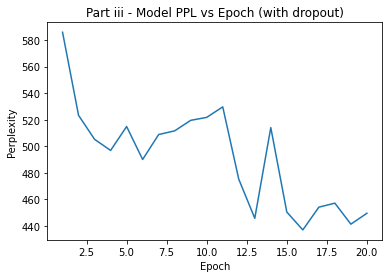

In [26]:
import matplotlib.pyplot as plt
plt.plot(epoch_plot_iii, perplexity_plot_iii)
plt.title('Part iii - Model PPL vs Epoch (with dropout)')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')

In [21]:
###############################################################################
# Main code --> (vi) - (vii)
###############################################################################
# import model

print()
print()
print('-'*89)
print('--- Part vi ---')
print('-'*89)



-----------------------------------------------------------------------------------------
--- Part vi ---
-----------------------------------------------------------------------------------------


In [23]:
###########################################################################
# Build the model
###########################################################################

ntokens = len(corpus.dictionary)
model = FNNModelDropout(ntokens, args.emsize, args.emsize, args.ngram_size, True, args.dropout).to(device)

# using negative log likelihood
criterion = nn.NLLLoss()

# Loop over epochs.
lr = args.lr
best_val_loss = None
best_perplexity = 999999999999999

#Empty arrray to store perplexity & epoch
perplexity_plot_vi = []
epoch_plot_vi = []

# At any point you can hit Ctrl + C to break out of training early.
try:
    for epoch in range(1, args.epochs+1):
        epoch_start_time = time.time()
        train()
        val_loss = evaluate(val_data)
        print('-' * 89)
        print('| end of epoch {:3d} | time: {:5.2f}s | valid loss {:5.2f} | '
            'valid ppl {:8.2f}'.format(epoch, (time.time() - epoch_start_time),
                                           val_loss, math.exp(val_loss)))
        print('-' * 89)
        
        # Save the model if the perplexity is the best seen
        perplexity = math.exp(val_loss)
        perplexity_plot_vi.append(perplexity)
        epoch_plot_vi.append(epoch)
        if perplexity < best_perplexity:
            with open(args.save, 'wb') as f:
                torch.save(model, f)         
            best_perplexity = perplexity
        else:
            # Anneal the learning rate if no improvement has been seen in the validation dataset.
            lr /= 2.0
            
except KeyboardInterrupt:
    print('-' * 89)
    print('Exiting from training early')

# Load the best saved model.
with open(args.save, 'rb') as f:
    model = torch.load(f)

# Run on test data.
test_loss = evaluate(test_data)
print('=' * 89)
print('| End of training | test loss {:5.2f} | test ppl {:8.2f}'.format(
        test_loss, math.exp(test_loss)))
print('=' * 89)

# saving to onnx format
if len(args.onnx_export) > 0:
    # Export the model in ONNX format.
    export_onnx(args.onnx_export, batch_size=1, seq_len=args.batch_size)

| epoch   1 |   200/59674 batches | lr 0.0010 | ms/batch  4.10 | loss  9.21 | ppl  9974.18
| epoch   1 |   400/59674 batches | lr 0.0010 | ms/batch  3.93 | loss  8.77 | ppl  6463.67
| epoch   1 |   600/59674 batches | lr 0.0010 | ms/batch  3.65 | loss  8.42 | ppl  4549.75
| epoch   1 |   800/59674 batches | lr 0.0010 | ms/batch  3.52 | loss  8.46 | ppl  4742.33
| epoch   1 |  1000/59674 batches | lr 0.0010 | ms/batch  3.65 | loss  8.25 | ppl  3819.06
| epoch   1 |  1200/59674 batches | lr 0.0010 | ms/batch  3.57 | loss  8.14 | ppl  3426.63
| epoch   1 |  1400/59674 batches | lr 0.0010 | ms/batch  3.70 | loss  8.17 | ppl  3545.04
| epoch   1 |  1600/59674 batches | lr 0.0010 | ms/batch  3.69 | loss  8.17 | ppl  3546.86
| epoch   1 |  1800/59674 batches | lr 0.0010 | ms/batch  3.54 | loss  8.09 | ppl  3268.53
| epoch   1 |  2000/59674 batches | lr 0.0010 | ms/batch  3.56 | loss  8.05 | ppl  3129.19
| epoch   1 |  2200/59674 batches | lr 0.0010 | ms/batch  3.67 | loss  8.14 | ppl  3437.61

| epoch   1 | 18400/59674 batches | lr 0.0010 | ms/batch  3.86 | loss  7.53 | ppl  1866.92
| epoch   1 | 18600/59674 batches | lr 0.0010 | ms/batch  3.90 | loss  7.72 | ppl  2262.01
| epoch   1 | 18800/59674 batches | lr 0.0010 | ms/batch  3.77 | loss  7.72 | ppl  2245.01
| epoch   1 | 19000/59674 batches | lr 0.0010 | ms/batch  3.78 | loss  7.50 | ppl  1809.10
| epoch   1 | 19200/59674 batches | lr 0.0010 | ms/batch  3.85 | loss  7.39 | ppl  1614.72
| epoch   1 | 19400/59674 batches | lr 0.0010 | ms/batch  3.95 | loss  7.69 | ppl  2191.76
| epoch   1 | 19600/59674 batches | lr 0.0010 | ms/batch  3.77 | loss  7.69 | ppl  2177.04
| epoch   1 | 19800/59674 batches | lr 0.0010 | ms/batch  3.79 | loss  7.42 | ppl  1666.04
| epoch   1 | 20000/59674 batches | lr 0.0010 | ms/batch  3.91 | loss  7.58 | ppl  1967.30
| epoch   1 | 20200/59674 batches | lr 0.0010 | ms/batch  3.89 | loss  7.56 | ppl  1924.08
| epoch   1 | 20400/59674 batches | lr 0.0010 | ms/batch  3.90 | loss  7.52 | ppl  1838.51

| epoch   1 | 36600/59674 batches | lr 0.0010 | ms/batch  3.73 | loss  7.68 | ppl  2161.11
| epoch   1 | 36800/59674 batches | lr 0.0010 | ms/batch  3.73 | loss  7.50 | ppl  1801.02
| epoch   1 | 37000/59674 batches | lr 0.0010 | ms/batch  3.79 | loss  6.71 | ppl   822.38
| epoch   1 | 37200/59674 batches | lr 0.0010 | ms/batch  3.81 | loss  7.62 | ppl  2040.67
| epoch   1 | 37400/59674 batches | lr 0.0010 | ms/batch  3.78 | loss  7.42 | ppl  1663.86
| epoch   1 | 37600/59674 batches | lr 0.0010 | ms/batch  4.31 | loss  7.51 | ppl  1833.05
| epoch   1 | 37800/59674 batches | lr 0.0010 | ms/batch  4.29 | loss  7.36 | ppl  1578.12
| epoch   1 | 38000/59674 batches | lr 0.0010 | ms/batch  4.33 | loss  7.55 | ppl  1896.93
| epoch   1 | 38200/59674 batches | lr 0.0010 | ms/batch  4.37 | loss  7.39 | ppl  1611.88
| epoch   1 | 38400/59674 batches | lr 0.0010 | ms/batch  4.32 | loss  7.41 | ppl  1660.29
| epoch   1 | 38600/59674 batches | lr 0.0010 | ms/batch  4.15 | loss  7.46 | ppl  1738.38

| epoch   1 | 54800/59674 batches | lr 0.0010 | ms/batch  3.76 | loss  7.45 | ppl  1719.47
| epoch   1 | 55000/59674 batches | lr 0.0010 | ms/batch  3.75 | loss  7.33 | ppl  1518.10
| epoch   1 | 55200/59674 batches | lr 0.0010 | ms/batch  3.75 | loss  7.27 | ppl  1440.28
| epoch   1 | 55400/59674 batches | lr 0.0010 | ms/batch  3.52 | loss  7.16 | ppl  1290.48
| epoch   1 | 55600/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.02 | ppl  1119.61
| epoch   1 | 55800/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.39 | ppl  1620.25
| epoch   1 | 56000/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.25 | ppl  1413.61
| epoch   1 | 56200/59674 batches | lr 0.0010 | ms/batch  3.55 | loss  7.71 | ppl  2230.47
| epoch   1 | 56400/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.08 | ppl  1189.83
| epoch   1 | 56600/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.48 | ppl  1780.07
| epoch   1 | 56800/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.50 | ppl  1809.17

| epoch   2 | 12800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.41 | ppl  1654.46
| epoch   2 | 13000/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  7.47 | ppl  1755.10
| epoch   2 | 13200/59674 batches | lr 0.0010 | ms/batch  3.49 | loss  7.39 | ppl  1626.10
| epoch   2 | 13400/59674 batches | lr 0.0010 | ms/batch  3.54 | loss  7.48 | ppl  1772.91
| epoch   2 | 13600/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.35 | ppl  1562.16
| epoch   2 | 13800/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.08 | ppl  1182.08
| epoch   2 | 14000/59674 batches | lr 0.0010 | ms/batch  3.54 | loss  7.13 | ppl  1244.10
| epoch   2 | 14200/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.27 | ppl  1440.69
| epoch   2 | 14400/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.22 | ppl  1366.29
| epoch   2 | 14600/59674 batches | lr 0.0010 | ms/batch  3.53 | loss  7.18 | ppl  1315.81
| epoch   2 | 14800/59674 batches | lr 0.0010 | ms/batch  3.51 | loss  7.10 | ppl  1211.02

| epoch   2 | 31000/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  6.91 | ppl  1005.35
| epoch   2 | 31200/59674 batches | lr 0.0010 | ms/batch  3.40 | loss  7.57 | ppl  1944.56
| epoch   2 | 31400/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.27 | ppl  1440.18
| epoch   2 | 31600/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.41 | ppl  1660.69
| epoch   2 | 31800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.46 | ppl  1741.21
| epoch   2 | 32000/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.06 | ppl  1166.79
| epoch   2 | 32200/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.50 | ppl  1800.22
| epoch   2 | 32400/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.41 | ppl  1646.95
| epoch   2 | 32600/59674 batches | lr 0.0010 | ms/batch  3.48 | loss  7.23 | ppl  1374.38
| epoch   2 | 32800/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.41 | ppl  1646.02
| epoch   2 | 33000/59674 batches | lr 0.0010 | ms/batch  3.56 | loss  7.18 | ppl  1315.33

| epoch   2 | 49200/59674 batches | lr 0.0010 | ms/batch  3.55 | loss  7.38 | ppl  1601.90
| epoch   2 | 49400/59674 batches | lr 0.0010 | ms/batch  3.37 | loss  7.44 | ppl  1697.36
| epoch   2 | 49600/59674 batches | lr 0.0010 | ms/batch  3.47 | loss  7.57 | ppl  1934.63
| epoch   2 | 49800/59674 batches | lr 0.0010 | ms/batch  3.34 | loss  7.49 | ppl  1792.55
| epoch   2 | 50000/59674 batches | lr 0.0010 | ms/batch  3.45 | loss  7.33 | ppl  1529.86
| epoch   2 | 50200/59674 batches | lr 0.0010 | ms/batch  3.41 | loss  7.35 | ppl  1551.20
| epoch   2 | 50400/59674 batches | lr 0.0010 | ms/batch  3.37 | loss  7.26 | ppl  1417.23
| epoch   2 | 50600/59674 batches | lr 0.0010 | ms/batch  3.44 | loss  7.40 | ppl  1638.18
| epoch   2 | 50800/59674 batches | lr 0.0010 | ms/batch  3.39 | loss  7.35 | ppl  1557.86
| epoch   2 | 51000/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.32 | ppl  1514.30
| epoch   2 | 51200/59674 batches | lr 0.0010 | ms/batch  3.38 | loss  7.39 | ppl  1615.19

| epoch   3 |  7200/59674 batches | lr 0.0005 | ms/batch  3.12 | loss  7.41 | ppl  1648.16
| epoch   3 |  7400/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.48 | ppl  1777.41
| epoch   3 |  7600/59674 batches | lr 0.0005 | ms/batch  3.10 | loss  7.44 | ppl  1694.85
| epoch   3 |  7800/59674 batches | lr 0.0005 | ms/batch  3.12 | loss  7.49 | ppl  1783.76
| epoch   3 |  8000/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.39 | ppl  1618.38
| epoch   3 |  8200/59674 batches | lr 0.0005 | ms/batch  3.17 | loss  7.42 | ppl  1672.84
| epoch   3 |  8400/59674 batches | lr 0.0005 | ms/batch  3.26 | loss  7.44 | ppl  1698.20
| epoch   3 |  8600/59674 batches | lr 0.0005 | ms/batch  3.31 | loss  7.63 | ppl  2052.40
| epoch   3 |  8800/59674 batches | lr 0.0005 | ms/batch  3.31 | loss  7.35 | ppl  1558.60
| epoch   3 |  9000/59674 batches | lr 0.0005 | ms/batch  3.28 | loss  7.25 | ppl  1409.16
| epoch   3 |  9200/59674 batches | lr 0.0005 | ms/batch  3.23 | loss  7.08 | ppl  1189.89

| epoch   3 | 25400/59674 batches | lr 0.0005 | ms/batch  3.23 | loss  7.20 | ppl  1344.18
| epoch   3 | 25600/59674 batches | lr 0.0005 | ms/batch  3.23 | loss  7.51 | ppl  1818.11
| epoch   3 | 25800/59674 batches | lr 0.0005 | ms/batch  3.29 | loss  7.45 | ppl  1713.80
| epoch   3 | 26000/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.19 | ppl  1324.10
| epoch   3 | 26200/59674 batches | lr 0.0005 | ms/batch  3.22 | loss  7.38 | ppl  1601.43
| epoch   3 | 26400/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.08 | ppl  1192.66
| epoch   3 | 26600/59674 batches | lr 0.0005 | ms/batch  3.10 | loss  7.10 | ppl  1217.44
| epoch   3 | 26800/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.46 | ppl  1730.74
| epoch   3 | 27000/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.44 | ppl  1708.54
| epoch   3 | 27200/59674 batches | lr 0.0005 | ms/batch  3.10 | loss  7.43 | ppl  1691.86
| epoch   3 | 27400/59674 batches | lr 0.0005 | ms/batch  3.12 | loss  7.47 | ppl  1746.70

| epoch   3 | 43600/59674 batches | lr 0.0005 | ms/batch  3.11 | loss  7.43 | ppl  1678.48
| epoch   3 | 43800/59674 batches | lr 0.0005 | ms/batch  3.31 | loss  7.19 | ppl  1331.97
| epoch   3 | 44000/59674 batches | lr 0.0005 | ms/batch  3.41 | loss  7.11 | ppl  1229.16
| epoch   3 | 44200/59674 batches | lr 0.0005 | ms/batch  3.42 | loss  7.21 | ppl  1354.07
| epoch   3 | 44400/59674 batches | lr 0.0005 | ms/batch  3.26 | loss  7.37 | ppl  1588.12
| epoch   3 | 44600/59674 batches | lr 0.0005 | ms/batch  3.35 | loss  7.39 | ppl  1618.89
| epoch   3 | 44800/59674 batches | lr 0.0005 | ms/batch  3.36 | loss  7.31 | ppl  1500.00
| epoch   3 | 45000/59674 batches | lr 0.0005 | ms/batch  3.16 | loss  7.37 | ppl  1585.47
| epoch   3 | 45200/59674 batches | lr 0.0005 | ms/batch  3.19 | loss  7.27 | ppl  1437.84
| epoch   3 | 45400/59674 batches | lr 0.0005 | ms/batch  3.22 | loss  7.28 | ppl  1457.87
| epoch   3 | 45600/59674 batches | lr 0.0005 | ms/batch  3.35 | loss  7.26 | ppl  1425.33

| epoch   4 |  1600/59674 batches | lr 0.0003 | ms/batch  3.14 | loss  7.45 | ppl  1712.07
| epoch   4 |  1800/59674 batches | lr 0.0003 | ms/batch  3.26 | loss  7.56 | ppl  1914.59
| epoch   4 |  2000/59674 batches | lr 0.0003 | ms/batch  3.60 | loss  7.44 | ppl  1695.66
| epoch   4 |  2200/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.51 | ppl  1832.74
| epoch   4 |  2400/59674 batches | lr 0.0003 | ms/batch  3.34 | loss  7.33 | ppl  1531.27
| epoch   4 |  2600/59674 batches | lr 0.0003 | ms/batch  3.18 | loss  7.33 | ppl  1528.29
| epoch   4 |  2800/59674 batches | lr 0.0003 | ms/batch  3.13 | loss  7.54 | ppl  1885.41
| epoch   4 |  3000/59674 batches | lr 0.0003 | ms/batch  3.13 | loss  7.18 | ppl  1314.73
| epoch   4 |  3200/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.40 | ppl  1627.89
| epoch   4 |  3400/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.25 | ppl  1414.33
| epoch   4 |  3600/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.38 | ppl  1600.43

| epoch   4 | 19800/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.26 | ppl  1425.54
| epoch   4 | 20000/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  7.22 | ppl  1362.14
| epoch   4 | 20200/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.31 | ppl  1497.93
| epoch   4 | 20400/59674 batches | lr 0.0003 | ms/batch  3.47 | loss  7.26 | ppl  1426.64
| epoch   4 | 20600/59674 batches | lr 0.0003 | ms/batch  3.45 | loss  7.35 | ppl  1551.94
| epoch   4 | 20800/59674 batches | lr 0.0003 | ms/batch  3.25 | loss  7.37 | ppl  1579.82
| epoch   4 | 21000/59674 batches | lr 0.0003 | ms/batch  3.21 | loss  7.29 | ppl  1468.93
| epoch   4 | 21200/59674 batches | lr 0.0003 | ms/batch  3.48 | loss  7.30 | ppl  1481.30
| epoch   4 | 21400/59674 batches | lr 0.0003 | ms/batch  3.78 | loss  7.09 | ppl  1202.32
| epoch   4 | 21600/59674 batches | lr 0.0003 | ms/batch  3.66 | loss  7.45 | ppl  1712.30
| epoch   4 | 21800/59674 batches | lr 0.0003 | ms/batch  3.69 | loss  7.33 | ppl  1522.94

| epoch   4 | 38000/59674 batches | lr 0.0003 | ms/batch  3.32 | loss  7.30 | ppl  1487.10
| epoch   4 | 38200/59674 batches | lr 0.0003 | ms/batch  3.28 | loss  7.39 | ppl  1621.71
| epoch   4 | 38400/59674 batches | lr 0.0003 | ms/batch  3.55 | loss  7.32 | ppl  1504.68
| epoch   4 | 38600/59674 batches | lr 0.0003 | ms/batch  3.36 | loss  7.36 | ppl  1565.55
| epoch   4 | 38800/59674 batches | lr 0.0003 | ms/batch  3.18 | loss  6.98 | ppl  1077.40
| epoch   4 | 39000/59674 batches | lr 0.0003 | ms/batch  3.41 | loss  7.29 | ppl  1461.89
| epoch   4 | 39200/59674 batches | lr 0.0003 | ms/batch  3.39 | loss  7.32 | ppl  1506.68
| epoch   4 | 39400/59674 batches | lr 0.0003 | ms/batch  3.56 | loss  7.55 | ppl  1908.96
| epoch   4 | 39600/59674 batches | lr 0.0003 | ms/batch  3.68 | loss  7.18 | ppl  1317.78
| epoch   4 | 39800/59674 batches | lr 0.0003 | ms/batch  3.57 | loss  7.49 | ppl  1788.05
| epoch   4 | 40000/59674 batches | lr 0.0003 | ms/batch  3.66 | loss  7.51 | ppl  1825.45

| epoch   4 | 56200/59674 batches | lr 0.0003 | ms/batch  3.25 | loss  7.81 | ppl  2464.43
| epoch   4 | 56400/59674 batches | lr 0.0003 | ms/batch  3.24 | loss  7.13 | ppl  1245.90
| epoch   4 | 56600/59674 batches | lr 0.0003 | ms/batch  3.33 | loss  7.50 | ppl  1804.49
| epoch   4 | 56800/59674 batches | lr 0.0003 | ms/batch  3.16 | loss  7.52 | ppl  1841.90
| epoch   4 | 57000/59674 batches | lr 0.0003 | ms/batch  3.50 | loss  7.66 | ppl  2112.05
| epoch   4 | 57200/59674 batches | lr 0.0003 | ms/batch  3.62 | loss  7.43 | ppl  1682.79
| epoch   4 | 57400/59674 batches | lr 0.0003 | ms/batch  3.79 | loss  7.21 | ppl  1358.56
| epoch   4 | 57600/59674 batches | lr 0.0003 | ms/batch  3.55 | loss  7.32 | ppl  1505.21
| epoch   4 | 57800/59674 batches | lr 0.0003 | ms/batch  3.52 | loss  7.48 | ppl  1770.29
| epoch   4 | 58000/59674 batches | lr 0.0003 | ms/batch  3.49 | loss  7.54 | ppl  1888.65
| epoch   4 | 58200/59674 batches | lr 0.0003 | ms/batch  3.67 | loss  7.63 | ppl  2052.23

| epoch   5 | 14200/59674 batches | lr 0.0001 | ms/batch  3.32 | loss  7.31 | ppl  1495.70
| epoch   5 | 14400/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.26 | ppl  1421.41
| epoch   5 | 14600/59674 batches | lr 0.0001 | ms/batch  3.50 | loss  7.18 | ppl  1310.47
| epoch   5 | 14800/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.17 | ppl  1300.00
| epoch   5 | 15000/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.30 | ppl  1483.03
| epoch   5 | 15200/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.59 | ppl  1971.59
| epoch   5 | 15400/59674 batches | lr 0.0001 | ms/batch  3.51 | loss  7.28 | ppl  1445.08
| epoch   5 | 15600/59674 batches | lr 0.0001 | ms/batch  3.41 | loss  7.67 | ppl  2142.76
| epoch   5 | 15800/59674 batches | lr 0.0001 | ms/batch  3.20 | loss  7.17 | ppl  1305.77
| epoch   5 | 16000/59674 batches | lr 0.0001 | ms/batch  3.13 | loss  7.43 | ppl  1680.00
| epoch   5 | 16200/59674 batches | lr 0.0001 | ms/batch  3.17 | loss  7.43 | ppl  1686.00

| epoch   5 | 32400/59674 batches | lr 0.0001 | ms/batch  3.46 | loss  7.34 | ppl  1537.82
| epoch   5 | 32600/59674 batches | lr 0.0001 | ms/batch  3.90 | loss  7.23 | ppl  1379.33
| epoch   5 | 32800/59674 batches | lr 0.0001 | ms/batch  3.63 | loss  7.40 | ppl  1641.65
| epoch   5 | 33000/59674 batches | lr 0.0001 | ms/batch  3.76 | loss  7.31 | ppl  1487.73
| epoch   5 | 33200/59674 batches | lr 0.0001 | ms/batch  3.75 | loss  7.52 | ppl  1845.82
| epoch   5 | 33400/59674 batches | lr 0.0001 | ms/batch  3.55 | loss  7.19 | ppl  1328.74
| epoch   5 | 33600/59674 batches | lr 0.0001 | ms/batch  3.63 | loss  7.45 | ppl  1724.17
| epoch   5 | 33800/59674 batches | lr 0.0001 | ms/batch  3.69 | loss  7.26 | ppl  1426.50
| epoch   5 | 34000/59674 batches | lr 0.0001 | ms/batch  3.29 | loss  7.16 | ppl  1290.33
| epoch   5 | 34200/59674 batches | lr 0.0001 | ms/batch  3.20 | loss  7.37 | ppl  1593.16
| epoch   5 | 34400/59674 batches | lr 0.0001 | ms/batch  3.25 | loss  7.37 | ppl  1580.95

| epoch   5 | 50600/59674 batches | lr 0.0001 | ms/batch  3.53 | loss  7.41 | ppl  1646.20
| epoch   5 | 50800/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.31 | ppl  1500.79
| epoch   5 | 51000/59674 batches | lr 0.0001 | ms/batch  3.54 | loss  7.34 | ppl  1539.28
| epoch   5 | 51200/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.40 | ppl  1630.57
| epoch   5 | 51400/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.27 | ppl  1433.73
| epoch   5 | 51600/59674 batches | lr 0.0001 | ms/batch  3.36 | loss  7.11 | ppl  1223.49
| epoch   5 | 51800/59674 batches | lr 0.0001 | ms/batch  3.26 | loss  7.21 | ppl  1346.86
| epoch   5 | 52000/59674 batches | lr 0.0001 | ms/batch  3.11 | loss  6.90 | ppl   993.32
| epoch   5 | 52200/59674 batches | lr 0.0001 | ms/batch  3.13 | loss  7.23 | ppl  1386.27
| epoch   5 | 52400/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.38 | ppl  1607.11
| epoch   5 | 52600/59674 batches | lr 0.0001 | ms/batch  3.11 | loss  7.57 | ppl  1937.48

| epoch   6 |  8600/59674 batches | lr 0.0001 | ms/batch  3.36 | loss  7.61 | ppl  2023.91
| epoch   6 |  8800/59674 batches | lr 0.0001 | ms/batch  3.29 | loss  7.43 | ppl  1686.93
| epoch   6 |  9000/59674 batches | lr 0.0001 | ms/batch  3.15 | loss  7.28 | ppl  1451.04
| epoch   6 |  9200/59674 batches | lr 0.0001 | ms/batch  3.19 | loss  7.04 | ppl  1146.86
| epoch   6 |  9400/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  7.61 | ppl  2026.38
| epoch   6 |  9600/59674 batches | lr 0.0001 | ms/batch  3.27 | loss  7.55 | ppl  1900.03
| epoch   6 |  9800/59674 batches | lr 0.0001 | ms/batch  3.17 | loss  7.44 | ppl  1706.50
| epoch   6 | 10000/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.26 | ppl  1429.07
| epoch   6 | 10200/59674 batches | lr 0.0001 | ms/batch  3.22 | loss  7.48 | ppl  1768.93
| epoch   6 | 10400/59674 batches | lr 0.0001 | ms/batch  3.14 | loss  7.32 | ppl  1508.20
| epoch   6 | 10600/59674 batches | lr 0.0001 | ms/batch  3.31 | loss  7.48 | ppl  1767.96

| epoch   6 | 26800/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.41 | ppl  1654.75
| epoch   6 | 27000/59674 batches | lr 0.0001 | ms/batch  3.19 | loss  7.39 | ppl  1613.13
| epoch   6 | 27200/59674 batches | lr 0.0001 | ms/batch  3.20 | loss  7.36 | ppl  1568.83
| epoch   6 | 27400/59674 batches | lr 0.0001 | ms/batch  3.26 | loss  7.38 | ppl  1608.18
| epoch   6 | 27600/59674 batches | lr 0.0001 | ms/batch  3.13 | loss  6.65 | ppl   772.48
| epoch   6 | 27800/59674 batches | lr 0.0001 | ms/batch  3.34 | loss  7.26 | ppl  1418.53
| epoch   6 | 28000/59674 batches | lr 0.0001 | ms/batch  3.23 | loss  7.01 | ppl  1107.59
| epoch   6 | 28200/59674 batches | lr 0.0001 | ms/batch  3.34 | loss  7.10 | ppl  1213.17
| epoch   6 | 28400/59674 batches | lr 0.0001 | ms/batch  3.22 | loss  7.20 | ppl  1342.33
| epoch   6 | 28600/59674 batches | lr 0.0001 | ms/batch  3.11 | loss  6.47 | ppl   648.38
| epoch   6 | 28800/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.36 | ppl  1570.24

| epoch   6 | 45000/59674 batches | lr 0.0001 | ms/batch  2.89 | loss  7.52 | ppl  1836.22
| epoch   6 | 45200/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.40 | ppl  1638.04
| epoch   6 | 45400/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.58 | ppl  1952.16
| epoch   6 | 45600/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.39 | ppl  1625.16
| epoch   6 | 45800/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  6.99 | ppl  1089.71
| epoch   6 | 46000/59674 batches | lr 0.0001 | ms/batch  2.93 | loss  7.65 | ppl  2094.25
| epoch   6 | 46200/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.24 | ppl  1400.67
| epoch   6 | 46400/59674 batches | lr 0.0001 | ms/batch  2.89 | loss  7.44 | ppl  1705.89
| epoch   6 | 46600/59674 batches | lr 0.0001 | ms/batch  2.89 | loss  7.51 | ppl  1834.34
| epoch   6 | 46800/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.44 | ppl  1707.78
| epoch   6 | 47000/59674 batches | lr 0.0001 | ms/batch  2.91 | loss  7.57 | ppl  1938.75

| epoch   7 |  3000/59674 batches | lr 0.0001 | ms/batch  2.89 | loss  7.17 | ppl  1304.22
| epoch   7 |  3200/59674 batches | lr 0.0001 | ms/batch  2.90 | loss  7.37 | ppl  1588.56
| epoch   7 |  3400/59674 batches | lr 0.0001 | ms/batch  3.00 | loss  7.27 | ppl  1443.73
| epoch   7 |  3600/59674 batches | lr 0.0001 | ms/batch  2.98 | loss  7.38 | ppl  1605.02
| epoch   7 |  3800/59674 batches | lr 0.0001 | ms/batch  3.22 | loss  7.39 | ppl  1624.62
| epoch   7 |  4000/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.31 | ppl  1498.58
| epoch   7 |  4200/59674 batches | lr 0.0001 | ms/batch  3.45 | loss  7.34 | ppl  1544.21
| epoch   7 |  4400/59674 batches | lr 0.0001 | ms/batch  3.39 | loss  7.31 | ppl  1493.54
| epoch   7 |  4600/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.58 | ppl  1955.01
| epoch   7 |  4800/59674 batches | lr 0.0001 | ms/batch  3.49 | loss  7.19 | ppl  1327.79
| epoch   7 |  5000/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.37 | ppl  1594.02

| epoch   7 | 21200/59674 batches | lr 0.0001 | ms/batch  3.37 | loss  7.23 | ppl  1385.40
| epoch   7 | 21400/59674 batches | lr 0.0001 | ms/batch  3.21 | loss  7.18 | ppl  1309.41
| epoch   7 | 21600/59674 batches | lr 0.0001 | ms/batch  3.28 | loss  7.42 | ppl  1673.86
| epoch   7 | 21800/59674 batches | lr 0.0001 | ms/batch  3.27 | loss  7.34 | ppl  1539.53
| epoch   7 | 22000/59674 batches | lr 0.0001 | ms/batch  3.25 | loss  7.47 | ppl  1762.46
| epoch   7 | 22200/59674 batches | lr 0.0001 | ms/batch  3.30 | loss  7.32 | ppl  1506.31
| epoch   7 | 22400/59674 batches | lr 0.0001 | ms/batch  3.24 | loss  7.35 | ppl  1552.58
| epoch   7 | 22600/59674 batches | lr 0.0001 | ms/batch  3.22 | loss  7.15 | ppl  1267.97
| epoch   7 | 22800/59674 batches | lr 0.0001 | ms/batch  3.30 | loss  7.46 | ppl  1742.50
| epoch   7 | 23000/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  6.91 | ppl  1007.18
| epoch   7 | 23200/59674 batches | lr 0.0001 | ms/batch  3.46 | loss  7.24 | ppl  1392.25

| epoch   7 | 39400/59674 batches | lr 0.0001 | ms/batch  3.11 | loss  7.63 | ppl  2049.11
| epoch   7 | 39600/59674 batches | lr 0.0001 | ms/batch  3.24 | loss  7.17 | ppl  1303.68
| epoch   7 | 39800/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.64 | ppl  2083.13
| epoch   7 | 40000/59674 batches | lr 0.0001 | ms/batch  3.21 | loss  7.62 | ppl  2045.86
| epoch   7 | 40200/59674 batches | lr 0.0001 | ms/batch  3.23 | loss  7.44 | ppl  1711.05
| epoch   7 | 40400/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.74 | ppl  2306.43
| epoch   7 | 40600/59674 batches | lr 0.0001 | ms/batch  3.13 | loss  7.42 | ppl  1669.41
| epoch   7 | 40800/59674 batches | lr 0.0001 | ms/batch  3.21 | loss  7.41 | ppl  1653.55
| epoch   7 | 41000/59674 batches | lr 0.0001 | ms/batch  3.11 | loss  7.16 | ppl  1293.07
| epoch   7 | 41200/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.49 | ppl  1795.49
| epoch   7 | 41400/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.46 | ppl  1744.99

| epoch   7 | 57600/59674 batches | lr 0.0001 | ms/batch  3.28 | loss  7.29 | ppl  1466.91
| epoch   7 | 57800/59674 batches | lr 0.0001 | ms/batch  3.35 | loss  7.54 | ppl  1878.20
| epoch   7 | 58000/59674 batches | lr 0.0001 | ms/batch  3.44 | loss  7.58 | ppl  1954.23
| epoch   7 | 58200/59674 batches | lr 0.0001 | ms/batch  3.59 | loss  7.65 | ppl  2100.89
| epoch   7 | 58400/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.49 | ppl  1793.78
| epoch   7 | 58600/59674 batches | lr 0.0001 | ms/batch  3.13 | loss  7.49 | ppl  1784.00
| epoch   7 | 58800/59674 batches | lr 0.0001 | ms/batch  3.55 | loss  7.52 | ppl  1852.62
| epoch   7 | 59000/59674 batches | lr 0.0001 | ms/batch  3.57 | loss  7.29 | ppl  1458.73
| epoch   7 | 59200/59674 batches | lr 0.0001 | ms/batch  3.50 | loss  7.51 | ppl  1833.84
| epoch   7 | 59400/59674 batches | lr 0.0001 | ms/batch  3.57 | loss  7.47 | ppl  1755.32
| epoch   7 | 59600/59674 batches | lr 0.0001 | ms/batch  3.66 | loss  7.33 | ppl  1524.02

| epoch   8 | 15600/59674 batches | lr 0.0001 | ms/batch  3.42 | loss  7.66 | ppl  2131.15
| epoch   8 | 15800/59674 batches | lr 0.0001 | ms/batch  3.72 | loss  7.27 | ppl  1434.85
| epoch   8 | 16000/59674 batches | lr 0.0001 | ms/batch  3.53 | loss  7.40 | ppl  1636.95
| epoch   8 | 16200/59674 batches | lr 0.0001 | ms/batch  3.64 | loss  7.55 | ppl  1899.32
| epoch   8 | 16400/59674 batches | lr 0.0001 | ms/batch  3.60 | loss  7.62 | ppl  2030.70
| epoch   8 | 16600/59674 batches | lr 0.0001 | ms/batch  3.67 | loss  7.21 | ppl  1352.87
| epoch   8 | 16800/59674 batches | lr 0.0001 | ms/batch  3.65 | loss  7.35 | ppl  1552.63
| epoch   8 | 17000/59674 batches | lr 0.0001 | ms/batch  3.61 | loss  7.05 | ppl  1155.43
| epoch   8 | 17200/59674 batches | lr 0.0001 | ms/batch  3.45 | loss  7.30 | ppl  1486.27
| epoch   8 | 17400/59674 batches | lr 0.0001 | ms/batch  3.23 | loss  7.01 | ppl  1112.30
| epoch   8 | 17600/59674 batches | lr 0.0001 | ms/batch  3.40 | loss  7.44 | ppl  1710.17

| epoch   8 | 33800/59674 batches | lr 0.0001 | ms/batch  3.50 | loss  7.33 | ppl  1520.98
| epoch   8 | 34000/59674 batches | lr 0.0001 | ms/batch  3.56 | loss  7.16 | ppl  1290.32
| epoch   8 | 34200/59674 batches | lr 0.0001 | ms/batch  3.51 | loss  7.46 | ppl  1731.48
| epoch   8 | 34400/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.45 | ppl  1714.87
| epoch   8 | 34600/59674 batches | lr 0.0001 | ms/batch  3.47 | loss  7.25 | ppl  1401.44
| epoch   8 | 34800/59674 batches | lr 0.0001 | ms/batch  3.48 | loss  7.26 | ppl  1425.69
| epoch   8 | 35000/59674 batches | lr 0.0001 | ms/batch  3.33 | loss  6.80 | ppl   901.67
| epoch   8 | 35200/59674 batches | lr 0.0001 | ms/batch  3.25 | loss  7.08 | ppl  1189.08
| epoch   8 | 35400/59674 batches | lr 0.0001 | ms/batch  3.12 | loss  7.32 | ppl  1515.14
| epoch   8 | 35600/59674 batches | lr 0.0001 | ms/batch  3.38 | loss  7.23 | ppl  1383.18
| epoch   8 | 35800/59674 batches | lr 0.0001 | ms/batch  3.33 | loss  7.08 | ppl  1193.14

| epoch   8 | 52000/59674 batches | lr 0.0001 | ms/batch  2.97 | loss  6.96 | ppl  1057.29
| epoch   8 | 52200/59674 batches | lr 0.0001 | ms/batch  3.00 | loss  7.26 | ppl  1429.07
| epoch   8 | 52400/59674 batches | lr 0.0001 | ms/batch  3.07 | loss  7.34 | ppl  1537.65
| epoch   8 | 52600/59674 batches | lr 0.0001 | ms/batch  2.98 | loss  7.54 | ppl  1882.57
| epoch   8 | 52800/59674 batches | lr 0.0001 | ms/batch  2.99 | loss  7.44 | ppl  1707.92
| epoch   8 | 53000/59674 batches | lr 0.0001 | ms/batch  2.98 | loss  7.19 | ppl  1320.70
| epoch   8 | 53200/59674 batches | lr 0.0001 | ms/batch  3.00 | loss  7.44 | ppl  1695.98
| epoch   8 | 53400/59674 batches | lr 0.0001 | ms/batch  3.05 | loss  7.38 | ppl  1608.66
| epoch   8 | 53600/59674 batches | lr 0.0001 | ms/batch  3.23 | loss  7.46 | ppl  1734.12
| epoch   8 | 53800/59674 batches | lr 0.0001 | ms/batch  3.26 | loss  7.43 | ppl  1691.18
| epoch   8 | 54000/59674 batches | lr 0.0001 | ms/batch  3.29 | loss  7.35 | ppl  1561.02

| epoch   9 | 10000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.36 | ppl  1564.64
| epoch   9 | 10200/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.50 | ppl  1815.80
| epoch   9 | 10400/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.29 | ppl  1472.74
| epoch   9 | 10600/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.54 | ppl  1880.69
| epoch   9 | 10800/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.51 | ppl  1827.73
| epoch   9 | 11000/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.45 | ppl  1719.01
| epoch   9 | 11200/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.40 | ppl  1631.97
| epoch   9 | 11400/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.45 | ppl  1724.59
| epoch   9 | 11600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.56 | ppl  1922.11
| epoch   9 | 11800/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.41 | ppl  1646.95
| epoch   9 | 12000/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.18 | ppl  1313.68

| epoch   9 | 28200/59674 batches | lr 0.0000 | ms/batch  2.97 | loss  7.13 | ppl  1251.75
| epoch   9 | 28400/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.26 | ppl  1426.81
| epoch   9 | 28600/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  6.64 | ppl   763.56
| epoch   9 | 28800/59674 batches | lr 0.0000 | ms/batch  2.93 | loss  7.45 | ppl  1727.97
| epoch   9 | 29000/59674 batches | lr 0.0000 | ms/batch  2.93 | loss  7.47 | ppl  1751.14
| epoch   9 | 29200/59674 batches | lr 0.0000 | ms/batch  2.94 | loss  7.41 | ppl  1652.86
| epoch   9 | 29400/59674 batches | lr 0.0000 | ms/batch  2.93 | loss  6.98 | ppl  1078.00
| epoch   9 | 29600/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.33 | ppl  1523.54
| epoch   9 | 29800/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.49 | ppl  1786.68
| epoch   9 | 30000/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.26 | ppl  1415.88
| epoch   9 | 30200/59674 batches | lr 0.0000 | ms/batch  2.92 | loss  7.14 | ppl  1266.45

| epoch   9 | 46400/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.27 | ppl  1441.69
| epoch   9 | 46600/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.37 | ppl  1580.97
| epoch   9 | 46800/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.30 | ppl  1472.97
| epoch   9 | 47000/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.48 | ppl  1774.56
| epoch   9 | 47200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.51 | ppl  1828.45
| epoch   9 | 47400/59674 batches | lr 0.0000 | ms/batch  2.91 | loss  7.32 | ppl  1515.85
| epoch   9 | 47600/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.25 | ppl  1405.33
| epoch   9 | 47800/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.45 | ppl  1722.47
| epoch   9 | 48000/59674 batches | lr 0.0000 | ms/batch  2.91 | loss  7.27 | ppl  1440.82
| epoch   9 | 48200/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.41 | ppl  1648.00
| epoch   9 | 48400/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.43 | ppl  1688.69

| epoch  10 |  4400/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.80 | ppl  2443.21
| epoch  10 |  4600/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  8.16 | ppl  3486.97
| epoch  10 |  4800/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.56 | ppl  1924.68
| epoch  10 |  5000/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.82 | ppl  2494.69
| epoch  10 |  5200/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.86 | ppl  2592.84
| epoch  10 |  5400/59674 batches | lr 0.0000 | ms/batch  3.73 | loss  7.52 | ppl  1849.00
| epoch  10 |  5600/59674 batches | lr 0.0000 | ms/batch  3.67 | loss  7.89 | ppl  2682.14
| epoch  10 |  5800/59674 batches | lr 0.0000 | ms/batch  3.73 | loss  7.64 | ppl  2084.58
| epoch  10 |  6000/59674 batches | lr 0.0000 | ms/batch  4.08 | loss  7.29 | ppl  1471.65
| epoch  10 |  6200/59674 batches | lr 0.0000 | ms/batch  3.95 | loss  7.60 | ppl  2000.61
| epoch  10 |  6400/59674 batches | lr 0.0000 | ms/batch  3.69 | loss  7.84 | ppl  2533.94

| epoch  10 | 22600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.37 | ppl  1589.54
| epoch  10 | 22800/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.72 | ppl  2259.88
| epoch  10 | 23000/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.15 | ppl  1278.96
| epoch  10 | 23200/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.56 | ppl  1924.05
| epoch  10 | 23400/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.84 | ppl  2536.00
| epoch  10 | 23600/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.64 | ppl  2089.01
| epoch  10 | 23800/59674 batches | lr 0.0000 | ms/batch  3.53 | loss  7.89 | ppl  2666.38
| epoch  10 | 24000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.78 | ppl  2401.26
| epoch  10 | 24200/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.36 | ppl  1565.91
| epoch  10 | 24400/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.19 | ppl  1321.86
| epoch  10 | 24600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.61 | ppl  2022.42

| epoch  10 | 40800/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.64 | ppl  2077.52
| epoch  10 | 41000/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.32 | ppl  1510.52
| epoch  10 | 41200/59674 batches | lr 0.0000 | ms/batch  3.24 | loss  7.57 | ppl  1947.53
| epoch  10 | 41400/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.58 | ppl  1964.09
| epoch  10 | 41600/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.26 | ppl  1425.50
| epoch  10 | 41800/59674 batches | lr 0.0000 | ms/batch  3.68 | loss  7.13 | ppl  1248.71
| epoch  10 | 42000/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.80 | ppl  2445.80
| epoch  10 | 42200/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.38 | ppl  1604.86
| epoch  10 | 42400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  6.72 | ppl   829.82
| epoch  10 | 42600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.07 | ppl  1173.85
| epoch  10 | 42800/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.18 | ppl  1316.39

| epoch  10 | 59000/59674 batches | lr 0.0000 | ms/batch  3.21 | loss  7.33 | ppl  1529.61
| epoch  10 | 59200/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.54 | ppl  1889.91
| epoch  10 | 59400/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.44 | ppl  1702.96
| epoch  10 | 59600/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.44 | ppl  1697.14
-----------------------------------------------------------------------------------------
| end of epoch  10 | time: 199.57s | valid loss  6.29 | valid ppl   539.66
-----------------------------------------------------------------------------------------
| epoch  11 |   200/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.71 | ppl  2233.79
| epoch  11 |   400/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.61 | ppl  2025.18
| epoch  11 |   600/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.32 | ppl  1506.89
| epoch  11 |   800/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.54 | ppl  1881.36
| epoch  11 |  10

| epoch  11 | 17000/59674 batches | lr 0.0000 | ms/batch  3.21 | loss  6.95 | ppl  1047.66
| epoch  11 | 17200/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.32 | ppl  1510.90
| epoch  11 | 17400/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  6.88 | ppl   972.98
| epoch  11 | 17600/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.40 | ppl  1632.24
| epoch  11 | 17800/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.30 | ppl  1477.26
| epoch  11 | 18000/59674 batches | lr 0.0000 | ms/batch  3.53 | loss  6.78 | ppl   882.08
| epoch  11 | 18200/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.59 | ppl  1985.42
| epoch  11 | 18400/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.29 | ppl  1468.29
| epoch  11 | 18600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.46 | ppl  1732.91
| epoch  11 | 18800/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.46 | ppl  1732.97
| epoch  11 | 19000/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.32 | ppl  1517.06

| epoch  11 | 35200/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.11 | ppl  1222.60
| epoch  11 | 35400/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.27 | ppl  1435.18
| epoch  11 | 35600/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.15 | ppl  1275.55
| epoch  11 | 35800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.19 | ppl  1329.46
| epoch  11 | 36000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.40 | ppl  1634.35
| epoch  11 | 36200/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.30 | ppl  1474.60
| epoch  11 | 36400/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.50 | ppl  1802.79
| epoch  11 | 36600/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.58 | ppl  1961.93
| epoch  11 | 36800/59674 batches | lr 0.0000 | ms/batch  3.55 | loss  7.32 | ppl  1503.26
| epoch  11 | 37000/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  6.53 | ppl   685.50
| epoch  11 | 37200/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.52 | ppl  1844.23

| epoch  11 | 53400/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.32 | ppl  1508.47
| epoch  11 | 53600/59674 batches | lr 0.0000 | ms/batch  2.98 | loss  7.43 | ppl  1679.64
| epoch  11 | 53800/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.39 | ppl  1616.40
| epoch  11 | 54000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.33 | ppl  1529.22
| epoch  11 | 54200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.44 | ppl  1695.35
| epoch  11 | 54400/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.30 | ppl  1482.55
| epoch  11 | 54600/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.48 | ppl  1770.49
| epoch  11 | 54800/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.35 | ppl  1563.50
| epoch  11 | 55000/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.40 | ppl  1630.63
| epoch  11 | 55200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.28 | ppl  1455.34
| epoch  11 | 55400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.23 | ppl  1375.32

| epoch  12 | 11400/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.73 | ppl  2280.62
| epoch  12 | 11600/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.81 | ppl  2473.20
| epoch  12 | 11800/59674 batches | lr 0.0000 | ms/batch  3.04 | loss  7.55 | ppl  1905.65
| epoch  12 | 12000/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  7.40 | ppl  1634.47
| epoch  12 | 12200/59674 batches | lr 0.0000 | ms/batch  3.34 | loss  7.67 | ppl  2148.66
| epoch  12 | 12400/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.60 | ppl  2006.87
| epoch  12 | 12600/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.43 | ppl  1688.80
| epoch  12 | 12800/59674 batches | lr 0.0000 | ms/batch  3.60 | loss  7.70 | ppl  2205.33
| epoch  12 | 13000/59674 batches | lr 0.0000 | ms/batch  2.92 | loss  7.60 | ppl  1996.25
| epoch  12 | 13200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.58 | ppl  1956.32
| epoch  12 | 13400/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.73 | ppl  2270.43

| epoch  12 | 29600/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.51 | ppl  1823.26
| epoch  12 | 29800/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.66 | ppl  2126.15
| epoch  12 | 30000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.42 | ppl  1663.96
| epoch  12 | 30200/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.28 | ppl  1446.78
| epoch  12 | 30400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.48 | ppl  1769.93
| epoch  12 | 30600/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.23 | ppl  1382.56
| epoch  12 | 30800/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.48 | ppl  1763.97
| epoch  12 | 31000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.23 | ppl  1379.36
| epoch  12 | 31200/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  8.06 | ppl  3162.07
| epoch  12 | 31400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.57 | ppl  1944.79
| epoch  12 | 31600/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.73 | ppl  2285.96

| epoch  12 | 47800/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.69 | ppl  2177.44
| epoch  12 | 48000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.42 | ppl  1660.89
| epoch  12 | 48200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.69 | ppl  2178.30
| epoch  12 | 48400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.75 | ppl  2330.25
| epoch  12 | 48600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.47 | ppl  1756.39
| epoch  12 | 48800/59674 batches | lr 0.0000 | ms/batch  2.98 | loss  7.27 | ppl  1439.95
| epoch  12 | 49000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.76 | ppl  2342.89
| epoch  12 | 49200/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.70 | ppl  2201.38
| epoch  12 | 49400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.83 | ppl  2513.93
| epoch  12 | 49600/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.81 | ppl  2465.53
| epoch  12 | 49800/59674 batches | lr 0.0000 | ms/batch  2.87 | loss  7.79 | ppl  2409.78

| epoch  13 |  5800/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.46 | ppl  1736.43
| epoch  13 |  6000/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.17 | ppl  1301.26
| epoch  13 |  6200/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.45 | ppl  1719.91
| epoch  13 |  6400/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.64 | ppl  2073.11
| epoch  13 |  6600/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.74 | ppl  2298.85
| epoch  13 |  6800/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.61 | ppl  2016.54
| epoch  13 |  7000/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.70 | ppl  2213.83
| epoch  13 |  7200/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.62 | ppl  2045.42
| epoch  13 |  7400/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.88 | ppl  2631.82
| epoch  13 |  7600/59674 batches | lr 0.0000 | ms/batch  2.88 | loss  7.75 | ppl  2328.16
| epoch  13 |  7800/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.72 | ppl  2251.91

| epoch  13 | 24000/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.50 | ppl  1800.68
| epoch  13 | 24200/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.23 | ppl  1383.39
| epoch  13 | 24400/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.01 | ppl  1109.38
| epoch  13 | 24600/59674 batches | lr 0.0000 | ms/batch  3.42 | loss  7.39 | ppl  1621.31
| epoch  13 | 24800/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.00 | ppl  1095.00
| epoch  13 | 25000/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.64 | ppl  2075.55
| epoch  13 | 25200/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.50 | ppl  1807.86
| epoch  13 | 25400/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.20 | ppl  1339.68
| epoch  13 | 25600/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.50 | ppl  1805.08
| epoch  13 | 25800/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  7.41 | ppl  1656.58
| epoch  13 | 26000/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.22 | ppl  1371.94

| epoch  13 | 42200/59674 batches | lr 0.0000 | ms/batch  2.94 | loss  7.29 | ppl  1465.46
| epoch  13 | 42400/59674 batches | lr 0.0000 | ms/batch  3.00 | loss  6.67 | ppl   785.65
| epoch  13 | 42600/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  6.97 | ppl  1066.75
| epoch  13 | 42800/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.15 | ppl  1272.76
| epoch  13 | 43000/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.55 | ppl  1892.14
| epoch  13 | 43200/59674 batches | lr 0.0000 | ms/batch  2.94 | loss  7.44 | ppl  1697.38
| epoch  13 | 43400/59674 batches | lr 0.0000 | ms/batch  2.99 | loss  7.26 | ppl  1428.01
| epoch  13 | 43600/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.37 | ppl  1591.47
| epoch  13 | 43800/59674 batches | lr 0.0000 | ms/batch  2.96 | loss  7.15 | ppl  1276.80
| epoch  13 | 44000/59674 batches | lr 0.0000 | ms/batch  3.00 | loss  7.13 | ppl  1249.02
| epoch  13 | 44200/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.28 | ppl  1444.05

| epoch  14 |   200/59674 batches | lr 0.0000 | ms/batch  3.04 | loss  7.91 | ppl  2725.16
| epoch  14 |   400/59674 batches | lr 0.0000 | ms/batch  2.98 | loss  7.89 | ppl  2668.34
| epoch  14 |   600/59674 batches | lr 0.0000 | ms/batch  3.00 | loss  7.55 | ppl  1899.34
| epoch  14 |   800/59674 batches | lr 0.0000 | ms/batch  2.97 | loss  7.85 | ppl  2555.57
| epoch  14 |  1000/59674 batches | lr 0.0000 | ms/batch  2.95 | loss  7.69 | ppl  2183.97
| epoch  14 |  1200/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.71 | ppl  2220.52
| epoch  14 |  1400/59674 batches | lr 0.0000 | ms/batch  2.96 | loss  8.01 | ppl  3015.09
| epoch  14 |  1600/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.80 | ppl  2438.88
| epoch  14 |  1800/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.89 | ppl  2681.63
| epoch  14 |  2000/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.83 | ppl  2508.26
| epoch  14 |  2200/59674 batches | lr 0.0000 | ms/batch  2.89 | loss  7.84 | ppl  2543.84

| epoch  14 | 18400/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.32 | ppl  1511.05
| epoch  14 | 18600/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.62 | ppl  2034.71
| epoch  14 | 18800/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.60 | ppl  1997.65
| epoch  14 | 19000/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.37 | ppl  1594.09
| epoch  14 | 19200/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.17 | ppl  1302.45
| epoch  14 | 19400/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.52 | ppl  1842.69
| epoch  14 | 19600/59674 batches | lr 0.0000 | ms/batch  3.00 | loss  7.56 | ppl  1923.29
| epoch  14 | 19800/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.44 | ppl  1708.01
| epoch  14 | 20000/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.40 | ppl  1639.35
| epoch  14 | 20200/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.40 | ppl  1641.95
| epoch  14 | 20400/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.33 | ppl  1531.30

| epoch  14 | 36600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.48 | ppl  1766.85
| epoch  14 | 36800/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.36 | ppl  1573.69
| epoch  14 | 37000/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  6.57 | ppl   710.06
| epoch  14 | 37200/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.56 | ppl  1926.63
| epoch  14 | 37400/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.30 | ppl  1487.36
| epoch  14 | 37600/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.40 | ppl  1642.61
| epoch  14 | 37800/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.38 | ppl  1602.75
| epoch  14 | 38000/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.38 | ppl  1596.65
| epoch  14 | 38200/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.38 | ppl  1603.71
| epoch  14 | 38400/59674 batches | lr 0.0000 | ms/batch  3.32 | loss  7.37 | ppl  1582.30
| epoch  14 | 38600/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.43 | ppl  1677.80

| epoch  14 | 54800/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.54 | ppl  1876.80
| epoch  14 | 55000/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.42 | ppl  1667.41
| epoch  14 | 55200/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.34 | ppl  1547.27
| epoch  14 | 55400/59674 batches | lr 0.0000 | ms/batch  3.20 | loss  7.22 | ppl  1360.38
| epoch  14 | 55600/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  6.96 | ppl  1053.42
| epoch  14 | 55800/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.41 | ppl  1658.68
| epoch  14 | 56000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.35 | ppl  1562.34
| epoch  14 | 56200/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.75 | ppl  2316.10
| epoch  14 | 56400/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.31 | ppl  1499.50
| epoch  14 | 56600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.60 | ppl  1997.92
| epoch  14 | 56800/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.60 | ppl  2008.13

| epoch  15 | 12800/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.66 | ppl  2112.04
| epoch  15 | 13000/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.60 | ppl  2003.65
| epoch  15 | 13200/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.62 | ppl  2039.73
| epoch  15 | 13400/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.68 | ppl  2165.61
| epoch  15 | 13600/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.45 | ppl  1724.61
| epoch  15 | 13800/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.10 | ppl  1212.99
| epoch  15 | 14000/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.31 | ppl  1500.96
| epoch  15 | 14200/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.40 | ppl  1631.45
| epoch  15 | 14400/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.34 | ppl  1538.29
| epoch  15 | 14600/59674 batches | lr 0.0000 | ms/batch  3.23 | loss  7.38 | ppl  1606.77
| epoch  15 | 14800/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.32 | ppl  1505.64

| epoch  15 | 31000/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.05 | ppl  1147.31
| epoch  15 | 31200/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.80 | ppl  2431.80
| epoch  15 | 31400/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.49 | ppl  1798.33
| epoch  15 | 31600/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.58 | ppl  1954.85
| epoch  15 | 31800/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.71 | ppl  2226.69
| epoch  15 | 32000/59674 batches | lr 0.0000 | ms/batch  3.21 | loss  7.23 | ppl  1384.64
| epoch  15 | 32200/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.67 | ppl  2149.88
| epoch  15 | 32400/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.56 | ppl  1923.08
| epoch  15 | 32600/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.38 | ppl  1608.18
| epoch  15 | 32800/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.61 | ppl  2009.96
| epoch  15 | 33000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.42 | ppl  1664.24

| epoch  15 | 49200/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.55 | ppl  1903.27
| epoch  15 | 49400/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.66 | ppl  2115.40
| epoch  15 | 49600/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.73 | ppl  2271.96
| epoch  15 | 49800/59674 batches | lr 0.0000 | ms/batch  3.23 | loss  7.74 | ppl  2287.94
| epoch  15 | 50000/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.54 | ppl  1886.78
| epoch  15 | 50200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.49 | ppl  1782.03
| epoch  15 | 50400/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.50 | ppl  1813.57
| epoch  15 | 50600/59674 batches | lr 0.0000 | ms/batch  3.12 | loss  7.54 | ppl  1888.13
| epoch  15 | 50800/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.51 | ppl  1826.19
| epoch  15 | 51000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.54 | ppl  1890.18
| epoch  15 | 51200/59674 batches | lr 0.0000 | ms/batch  3.26 | loss  7.55 | ppl  1904.71

| epoch  16 |  7200/59674 batches | lr 0.0000 | ms/batch  3.26 | loss  7.56 | ppl  1918.58
| epoch  16 |  7400/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.75 | ppl  2311.49
| epoch  16 |  7600/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.57 | ppl  1943.73
| epoch  16 |  7800/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.73 | ppl  2278.73
| epoch  16 |  8000/59674 batches | lr 0.0000 | ms/batch  3.29 | loss  7.63 | ppl  2067.87
| epoch  16 |  8200/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.55 | ppl  1907.30
| epoch  16 |  8400/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.68 | ppl  2158.41
| epoch  16 |  8600/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.85 | ppl  2567.14
| epoch  16 |  8800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.60 | ppl  1991.92
| epoch  16 |  9000/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.51 | ppl  1825.14
| epoch  16 |  9200/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.33 | ppl  1522.02

| epoch  16 | 25400/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.37 | ppl  1580.44
| epoch  16 | 25600/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.66 | ppl  2118.74
| epoch  16 | 25800/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.52 | ppl  1839.69
| epoch  16 | 26000/59674 batches | lr 0.0000 | ms/batch  2.97 | loss  7.28 | ppl  1449.07
| epoch  16 | 26200/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.54 | ppl  1878.64
| epoch  16 | 26400/59674 batches | lr 0.0000 | ms/batch  3.14 | loss  7.15 | ppl  1273.80
| epoch  16 | 26600/59674 batches | lr 0.0000 | ms/batch  3.23 | loss  7.09 | ppl  1202.46
| epoch  16 | 26800/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.65 | ppl  2106.57
| epoch  16 | 27000/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.50 | ppl  1812.20
| epoch  16 | 27200/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.52 | ppl  1842.06
| epoch  16 | 27400/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.52 | ppl  1839.77

| epoch  16 | 43600/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.51 | ppl  1834.63
| epoch  16 | 43800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.26 | ppl  1420.56
| epoch  16 | 44000/59674 batches | lr 0.0000 | ms/batch  3.50 | loss  7.25 | ppl  1403.63
| epoch  16 | 44200/59674 batches | lr 0.0000 | ms/batch  4.15 | loss  7.33 | ppl  1528.94
| epoch  16 | 44400/59674 batches | lr 0.0000 | ms/batch  4.00 | loss  7.54 | ppl  1878.56
| epoch  16 | 44600/59674 batches | lr 0.0000 | ms/batch  3.97 | loss  7.53 | ppl  1869.37
| epoch  16 | 44800/59674 batches | lr 0.0000 | ms/batch  3.96 | loss  7.54 | ppl  1882.81
| epoch  16 | 45000/59674 batches | lr 0.0000 | ms/batch  3.91 | loss  7.53 | ppl  1869.34
| epoch  16 | 45200/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.47 | ppl  1758.58
| epoch  16 | 45400/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.64 | ppl  2084.90
| epoch  16 | 45600/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.39 | ppl  1617.51

| epoch  17 |  1600/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.72 | ppl  2257.67
| epoch  17 |  1800/59674 batches | lr 0.0000 | ms/batch  3.23 | loss  7.76 | ppl  2340.54
| epoch  17 |  2000/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.63 | ppl  2055.26
| epoch  17 |  2200/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.70 | ppl  2216.76
| epoch  17 |  2400/59674 batches | lr 0.0000 | ms/batch  3.03 | loss  7.59 | ppl  1968.65
| epoch  17 |  2600/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.44 | ppl  1702.80
| epoch  17 |  2800/59674 batches | lr 0.0000 | ms/batch  3.21 | loss  7.83 | ppl  2509.75
| epoch  17 |  3000/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.33 | ppl  1532.83
| epoch  17 |  3200/59674 batches | lr 0.0000 | ms/batch  3.11 | loss  7.53 | ppl  1862.01
| epoch  17 |  3400/59674 batches | lr 0.0000 | ms/batch  2.92 | loss  7.43 | ppl  1687.48
| epoch  17 |  3600/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.53 | ppl  1872.10

| epoch  17 | 19800/59674 batches | lr 0.0000 | ms/batch  3.32 | loss  7.39 | ppl  1619.97
| epoch  17 | 20000/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.51 | ppl  1824.12
| epoch  17 | 20200/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.44 | ppl  1707.82
| epoch  17 | 20400/59674 batches | lr 0.0000 | ms/batch  3.98 | loss  7.41 | ppl  1651.35
| epoch  17 | 20600/59674 batches | lr 0.0000 | ms/batch  3.73 | loss  7.55 | ppl  1893.72
| epoch  17 | 20800/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.47 | ppl  1746.80
| epoch  17 | 21000/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.48 | ppl  1780.97
| epoch  17 | 21200/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.41 | ppl  1651.23
| epoch  17 | 21400/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.26 | ppl  1419.25
| epoch  17 | 21600/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.61 | ppl  2014.54
| epoch  17 | 21800/59674 batches | lr 0.0000 | ms/batch  3.97 | loss  7.49 | ppl  1793.10

| epoch  17 | 38000/59674 batches | lr 0.0000 | ms/batch  3.76 | loss  7.45 | ppl  1718.69
| epoch  17 | 38200/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.48 | ppl  1763.89
| epoch  17 | 38400/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.45 | ppl  1714.01
| epoch  17 | 38600/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.60 | ppl  2003.59
| epoch  17 | 38800/59674 batches | lr 0.0000 | ms/batch  3.09 | loss  7.13 | ppl  1246.44
| epoch  17 | 39000/59674 batches | lr 0.0000 | ms/batch  3.03 | loss  7.42 | ppl  1667.94
| epoch  17 | 39200/59674 batches | lr 0.0000 | ms/batch  3.26 | loss  7.40 | ppl  1641.28
| epoch  17 | 39400/59674 batches | lr 0.0000 | ms/batch  3.68 | loss  7.70 | ppl  2215.19
| epoch  17 | 39600/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.35 | ppl  1559.99
| epoch  17 | 39800/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.82 | ppl  2499.64
| epoch  17 | 40000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.79 | ppl  2418.91

| epoch  17 | 56200/59674 batches | lr 0.0000 | ms/batch  3.52 | loss  7.90 | ppl  2691.39
| epoch  17 | 56400/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.19 | ppl  1326.53
| epoch  17 | 56600/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.62 | ppl  2048.70
| epoch  17 | 56800/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.68 | ppl  2166.17
| epoch  17 | 57000/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.80 | ppl  2431.24
| epoch  17 | 57200/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.57 | ppl  1930.77
| epoch  17 | 57400/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.43 | ppl  1683.68
| epoch  17 | 57600/59674 batches | lr 0.0000 | ms/batch  3.26 | loss  7.46 | ppl  1734.74
| epoch  17 | 57800/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.70 | ppl  2212.09
| epoch  17 | 58000/59674 batches | lr 0.0000 | ms/batch  3.38 | loss  7.63 | ppl  2060.85
| epoch  17 | 58200/59674 batches | lr 0.0000 | ms/batch  3.43 | loss  7.91 | ppl  2715.45

| epoch  18 | 14200/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.46 | ppl  1728.73
| epoch  18 | 14400/59674 batches | lr 0.0000 | ms/batch  2.90 | loss  7.43 | ppl  1690.36
| epoch  18 | 14600/59674 batches | lr 0.0000 | ms/batch  3.08 | loss  7.38 | ppl  1599.60
| epoch  18 | 14800/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.30 | ppl  1476.03
| epoch  18 | 15000/59674 batches | lr 0.0000 | ms/batch  3.36 | loss  7.50 | ppl  1807.29
| epoch  18 | 15200/59674 batches | lr 0.0000 | ms/batch  3.06 | loss  7.82 | ppl  2487.67
| epoch  18 | 15400/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.32 | ppl  1505.47
| epoch  18 | 15600/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.97 | ppl  2903.81
| epoch  18 | 15800/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.30 | ppl  1480.64
| epoch  18 | 16000/59674 batches | lr 0.0000 | ms/batch  3.00 | loss  7.55 | ppl  1900.30
| epoch  18 | 16200/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.64 | ppl  2079.87

| epoch  18 | 32400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.67 | ppl  2135.18
| epoch  18 | 32600/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.43 | ppl  1693.30
| epoch  18 | 32800/59674 batches | lr 0.0000 | ms/batch  3.41 | loss  7.68 | ppl  2173.85
| epoch  18 | 33000/59674 batches | lr 0.0000 | ms/batch  3.10 | loss  7.46 | ppl  1728.85
| epoch  18 | 33200/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.86 | ppl  2600.94
| epoch  18 | 33400/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.36 | ppl  1579.66
| epoch  18 | 33600/59674 batches | lr 0.0000 | ms/batch  3.32 | loss  7.62 | ppl  2043.71
| epoch  18 | 33800/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.43 | ppl  1693.64
| epoch  18 | 34000/59674 batches | lr 0.0000 | ms/batch  3.15 | loss  7.32 | ppl  1506.36
| epoch  18 | 34200/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.66 | ppl  2120.36
| epoch  18 | 34400/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.63 | ppl  2050.10

| epoch  18 | 50600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.68 | ppl  2174.36
| epoch  18 | 50800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.56 | ppl  1917.15
| epoch  18 | 51000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.61 | ppl  2018.02
| epoch  18 | 51200/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.61 | ppl  2023.89
| epoch  18 | 51400/59674 batches | lr 0.0000 | ms/batch  3.40 | loss  7.48 | ppl  1774.21
| epoch  18 | 51600/59674 batches | lr 0.0000 | ms/batch  3.13 | loss  7.48 | ppl  1770.34
| epoch  18 | 51800/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.47 | ppl  1749.60
| epoch  18 | 52000/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.15 | ppl  1273.32
| epoch  18 | 52200/59674 batches | lr 0.0000 | ms/batch  3.22 | loss  7.39 | ppl  1618.50
| epoch  18 | 52400/59674 batches | lr 0.0000 | ms/batch  3.16 | loss  7.55 | ppl  1893.71
| epoch  18 | 52600/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.78 | ppl  2393.80

| epoch  19 |  8600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.74 | ppl  2306.90
| epoch  19 |  8800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.54 | ppl  1878.05
| epoch  19 |  9000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.55 | ppl  1898.37
| epoch  19 |  9200/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.30 | ppl  1487.49
| epoch  19 |  9400/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  7.79 | ppl  2414.57
| epoch  19 |  9600/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.66 | ppl  2115.09
| epoch  19 |  9800/59674 batches | lr 0.0000 | ms/batch  3.07 | loss  7.59 | ppl  1987.96
| epoch  19 | 10000/59674 batches | lr 0.0000 | ms/batch  3.25 | loss  7.44 | ppl  1709.01
| epoch  19 | 10200/59674 batches | lr 0.0000 | ms/batch  3.33 | loss  7.61 | ppl  2019.93
| epoch  19 | 10400/59674 batches | lr 0.0000 | ms/batch  3.03 | loss  7.40 | ppl  1643.91
| epoch  19 | 10600/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.64 | ppl  2087.92

| epoch  19 | 26800/59674 batches | lr 0.0000 | ms/batch  3.48 | loss  7.58 | ppl  1953.17
| epoch  19 | 27000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.46 | ppl  1740.66
| epoch  19 | 27200/59674 batches | lr 0.0000 | ms/batch  3.49 | loss  7.49 | ppl  1783.15
| epoch  19 | 27400/59674 batches | lr 0.0000 | ms/batch  3.51 | loss  7.54 | ppl  1890.45
| epoch  19 | 27600/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  6.76 | ppl   859.19
| epoch  19 | 27800/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.33 | ppl  1520.18
| epoch  19 | 28000/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.10 | ppl  1210.63
| epoch  19 | 28200/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.18 | ppl  1317.71
| epoch  19 | 28400/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.29 | ppl  1465.84
| epoch  19 | 28600/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  6.53 | ppl   688.79
| epoch  19 | 28800/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.51 | ppl  1824.09

| epoch  19 | 45000/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.48 | ppl  1764.66
| epoch  19 | 45200/59674 batches | lr 0.0000 | ms/batch  3.60 | loss  7.31 | ppl  1488.58
| epoch  19 | 45400/59674 batches | lr 0.0000 | ms/batch  3.63 | loss  7.51 | ppl  1832.36
| epoch  19 | 45600/59674 batches | lr 0.0000 | ms/batch  3.76 | loss  7.31 | ppl  1498.87
| epoch  19 | 45800/59674 batches | lr 0.0000 | ms/batch  3.71 | loss  7.02 | ppl  1118.08
| epoch  19 | 46000/59674 batches | lr 0.0000 | ms/batch  3.69 | loss  7.68 | ppl  2173.05
| epoch  19 | 46200/59674 batches | lr 0.0000 | ms/batch  3.57 | loss  7.22 | ppl  1364.78
| epoch  19 | 46400/59674 batches | lr 0.0000 | ms/batch  3.44 | loss  7.44 | ppl  1700.00
| epoch  19 | 46600/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.44 | ppl  1696.82
| epoch  19 | 46800/59674 batches | lr 0.0000 | ms/batch  3.35 | loss  7.34 | ppl  1545.76
| epoch  19 | 47000/59674 batches | lr 0.0000 | ms/batch  3.72 | loss  7.41 | ppl  1659.93

| epoch  20 |  3000/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.28 | ppl  1449.96
| epoch  20 |  3200/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.51 | ppl  1821.29
| epoch  20 |  3400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.41 | ppl  1654.25
| epoch  20 |  3600/59674 batches | lr 0.0000 | ms/batch  3.23 | loss  7.48 | ppl  1765.27
| epoch  20 |  3800/59674 batches | lr 0.0000 | ms/batch  3.31 | loss  7.49 | ppl  1783.75
| epoch  20 |  4000/59674 batches | lr 0.0000 | ms/batch  3.05 | loss  7.39 | ppl  1619.17
| epoch  20 |  4200/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.55 | ppl  1894.06
| epoch  20 |  4400/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.43 | ppl  1685.39
| epoch  20 |  4600/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.76 | ppl  2354.08
| epoch  20 |  4800/59674 batches | lr 0.0000 | ms/batch  3.07 | loss  7.34 | ppl  1536.03
| epoch  20 |  5000/59674 batches | lr 0.0000 | ms/batch  3.01 | loss  7.49 | ppl  1793.61

| epoch  20 | 21200/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.41 | ppl  1658.69
| epoch  20 | 21400/59674 batches | lr 0.0000 | ms/batch  3.47 | loss  7.31 | ppl  1500.93
| epoch  20 | 21600/59674 batches | lr 0.0000 | ms/batch  3.45 | loss  7.54 | ppl  1882.35
| epoch  20 | 21800/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.55 | ppl  1905.53
| epoch  20 | 22000/59674 batches | lr 0.0000 | ms/batch  3.39 | loss  7.49 | ppl  1781.48
| epoch  20 | 22200/59674 batches | lr 0.0000 | ms/batch  3.32 | loss  7.44 | ppl  1703.35
| epoch  20 | 22400/59674 batches | lr 0.0000 | ms/batch  3.04 | loss  7.60 | ppl  2005.81
| epoch  20 | 22600/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.29 | ppl  1465.53
| epoch  20 | 22800/59674 batches | lr 0.0000 | ms/batch  3.02 | loss  7.61 | ppl  2008.68
| epoch  20 | 23000/59674 batches | lr 0.0000 | ms/batch  3.30 | loss  7.17 | ppl  1305.99
| epoch  20 | 23200/59674 batches | lr 0.0000 | ms/batch  3.07 | loss  7.44 | ppl  1703.03

| epoch  20 | 39400/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.66 | ppl  2114.10
| epoch  20 | 39600/59674 batches | lr 0.0000 | ms/batch  3.64 | loss  7.26 | ppl  1417.70
| epoch  20 | 39800/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  7.66 | ppl  2120.27
| epoch  20 | 40000/59674 batches | lr 0.0000 | ms/batch  3.61 | loss  7.67 | ppl  2134.67
| epoch  20 | 40200/59674 batches | lr 0.0000 | ms/batch  3.58 | loss  7.62 | ppl  2048.64
| epoch  20 | 40400/59674 batches | lr 0.0000 | ms/batch  3.62 | loss  7.82 | ppl  2486.82
| epoch  20 | 40600/59674 batches | lr 0.0000 | ms/batch  3.65 | loss  7.48 | ppl  1764.13
| epoch  20 | 40800/59674 batches | lr 0.0000 | ms/batch  3.28 | loss  7.51 | ppl  1820.89
| epoch  20 | 41000/59674 batches | lr 0.0000 | ms/batch  3.46 | loss  7.28 | ppl  1448.32
| epoch  20 | 41200/59674 batches | lr 0.0000 | ms/batch  3.18 | loss  7.57 | ppl  1934.73
| epoch  20 | 41400/59674 batches | lr 0.0000 | ms/batch  3.19 | loss  7.69 | ppl  2178.32

| epoch  20 | 57600/59674 batches | lr 0.0000 | ms/batch  3.79 | loss  7.45 | ppl  1714.94
| epoch  20 | 57800/59674 batches | lr 0.0000 | ms/batch  4.04 | loss  7.69 | ppl  2183.76
| epoch  20 | 58000/59674 batches | lr 0.0000 | ms/batch  3.96 | loss  7.57 | ppl  1946.14
| epoch  20 | 58200/59674 batches | lr 0.0000 | ms/batch  3.99 | loss  7.71 | ppl  2232.33
| epoch  20 | 58400/59674 batches | lr 0.0000 | ms/batch  3.91 | loss  7.63 | ppl  2066.86
| epoch  20 | 58600/59674 batches | lr 0.0000 | ms/batch  3.37 | loss  7.62 | ppl  2041.38
| epoch  20 | 58800/59674 batches | lr 0.0000 | ms/batch  3.66 | loss  7.63 | ppl  2066.81
| epoch  20 | 59000/59674 batches | lr 0.0000 | ms/batch  3.27 | loss  7.54 | ppl  1881.39
| epoch  20 | 59200/59674 batches | lr 0.0000 | ms/batch  3.17 | loss  7.67 | ppl  2135.38
| epoch  20 | 59400/59674 batches | lr 0.0000 | ms/batch  3.03 | loss  7.58 | ppl  1963.68
| epoch  20 | 59600/59674 batches | lr 0.0000 | ms/batch  3.54 | loss  7.52 | ppl  1847.62

Text(0.5, 0, 'Epoch')

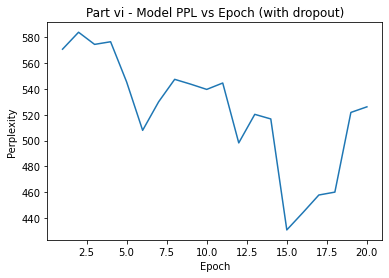

In [34]:
plt.plot(epoch_plot_vi, perplexity_plot_vi)
plt.title('Part vi - Model PPL vs Epoch (with dropout)')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')

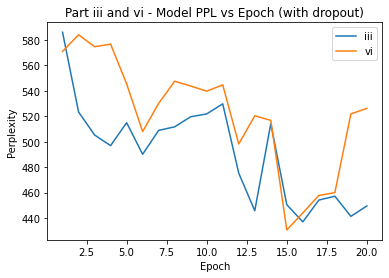

In [48]:
plt.plot(epoch_plot_iii, perplexity_plot_iii)
plt.plot(epoch_plot_vi, perplexity_plot_vi)
plt.title('Part iii and vi - Model PPL vs Epoch (with dropout)')
plt.ylabel('Perplexity')
plt.xlabel('Epoch')
plt.legend( ['iii', 'vi'])

## Generating Texts

In [10]:
#!/usr/bin/env python
# coding: utf-8


###############################################################################
# Language Modeling on Wikitext-2
#
# This file generates new sentences sampled from the language model
#
###############################################################################

import argparse

import torch

import data

# parser = argparse.ArgumentParser(description='PyTorch Wikitext-2 Language Model')

# # Model parameters.
# parser.add_argument('--data', type=str, default='./data/wikitext-2',
#                     help='location of the data corpus')
# parser.add_argument('--checkpoint', type=str, default='./model_dropout.pt',
#                     help='model checkpoint to use')
# parser.add_argument('--outf', type=str, default='generated.txt',
#                     help='output file for generated text')
# parser.add_argument('--words', type=int, default='1000',
#                     help='number of words to generate')
# parser.add_argument('--seed', type=int, default=1111,
#                     help='random seed')
# parser.add_argument('--cuda', action='store_true',
#                     help='use CUDA')
# parser.add_argument('--temperature', type=float, default=1.0,
#                     help='temperature - higher will increase diversity')
# parser.add_argument('--log-interval', type=int, default=100,
#                     help='reporting interval')
# args = parser.parse_args()

class Args:
  data = './data/wikitext-2'
  checkpoint = './model_dropout.pt'
  outf = 'generated.txt'
  words = 1000
  seed = 1111
  cuda =  False
  temperature = 1.0
  log_interval = 100

args=Args()

# used to append new word and remove the first word, creating a new set of 7 words
def modify_input(input, new_word):
    length = len(input[0])
    result = torch.cat([input.squeeze()[1:], new_word.view(-1)])
    result = result.view(1, length)
    return result

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)
if torch.cuda.is_available():
    if not args.cuda:
        print("WARNING: You have a CUDA device, so you should probably run with --cuda")

device = torch.device("cuda" if args.cuda else "cpu")

if args.temperature < 1e-3:
    parser.error("--temperature has to be greater or equal 1e-3")

with open(args.checkpoint, 'rb') as f:
    model = torch.load(f, map_location=torch.device('cpu')).to(device)
model.eval()

corpus = data.Corpus(args.data)
ntokens = len(corpus.dictionary)

input = torch.randint(ntokens, (1, 7), dtype=torch.long).to(device)

with open(args.outf, 'w', encoding='utf-8') as outf:
    with torch.no_grad():  # no tracking history
        for i in range(args.words):
            output = model(input)
            word_weights = output.squeeze().div(args.temperature).exp().cpu()
            word_idx = torch.multinomial(word_weights, 1)[0]
            input = modify_input(input, word_idx)

            word = corpus.dictionary.idx2word[word_idx]

            outf.write(word + ('\n' if i % 20 == 19 else ' '))

            if i % args.log_interval == 0:
                print('| Generated {}/{} words'.format(i, args.words))

| Generated 0/1000 words
| Generated 100/1000 words
| Generated 200/1000 words
| Generated 300/1000 words
| Generated 400/1000 words
| Generated 500/1000 words
| Generated 600/1000 words
| Generated 700/1000 words
| Generated 800/1000 words
| Generated 900/1000 words
